In [2]:
import pandas as pd
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
import string
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.manifold import TSNE


# Import des données

In [2]:
path_general = os.path.join(os.getcwd())
path_files_Nodes = os.path.join(os.getcwd(), "database", "Nodes")
path_files_Relationships = os.path.join(os.getcwd(), "database", "Relationships")
path_files_Everything = os.path.join(os.getcwd(), "database", "Everything")

## Import

In [3]:
# Liste des fichiers JSON
files = {
    "Tweet": os.path.join(path_files_Nodes, "Tweet.json"),
    "User": os.path.join(path_files_Nodes, "User.json"),  
    "Event": os.path.join(path_files_Nodes, "Event.json"),
    "Hashtag": os.path.join(path_files_Nodes, "Hashtag.json"),
    "IS_ABOUT": os.path.join(path_files_Relationships, "IS_ABOUT.json"),
    "HAS_HASHTAG": os.path.join(path_files_Relationships, "HAS_HASHTAG.json"),
    "HAS_CATEGORY": os.path.join(path_files_Relationships, "HAS_CATEGORY.json"),
    "POSTED": os.path.join(path_files_Relationships, "POSTED.json"),
    "PostCategory":os.path.join(path_files_Nodes, "PostCategory.json")
}

In [4]:
# Dictionnaire pour stocker les DataFrames
dataframes = {}

# Fonction pour charger un fichier JSON en DataFrame
def load_json_to_df(file_path, is_relationship):
    try:
        df = pd.read_json(file_path, lines=True)  # Lire le fichier JSON Lines

        if is_relationship:  # Cas des fichiers Relations
            df = df["r"].apply(pd.Series)
            df["start_id"] = df["start"].apply(lambda x: x["id"])
            df["end_id"] = df["end"].apply(lambda x: x["id"])
            df = df.drop(columns=["start", "end", "id"])  # Supprimer les colonnes inutiles et l'id de relation
        
        else:  # Cas des fichiers Nœuds
            df = df["n"].apply(pd.Series)  # Décomposer "n"
            df = pd.concat([df.drop(columns=["properties"]), df["properties"].apply(pd.Series)], axis=1)  # Extraire "properties"

        return df

    except Exception as e:
        print(f"Erreur lors du chargement de {file_path}: {e}")
        return None

# Charger chaque fichier en DataFrame
for name, path in files.items():
    is_relationship = name in ["POSTED", "IS_ABOUT", "HAS_HASHTAG","HAS_CATEGORY"]  # Identifier les fichiers Relations
    dataframes[name] = load_json_to_df(path, is_relationship)

    if dataframes[name] is not None:
        print(f"{name} chargé avec {len(dataframes[name])} lignes.")
        
        # Renommage des colonnes selon la table
        if name == "POSTED":
            dataframes[name].rename(columns={"start_id": "id_user", "end_id": "id_tweet"}, inplace=True)
        elif name == "IS_ABOUT":
            dataframes[name].rename(columns={"start_id": "id_tweet", "end_id": "id_event"}, inplace=True)
        elif name == "HAS_HASHTAG":
            dataframes[name].rename(columns={"start_id": "id_tweet", "end_id": "id_hashtag"}, inplace=True)
        elif name == "HAS_CATEGORY":
            dataframes[name].rename(columns={"start_id": "id_tweet", "end_id": "id_Postcategory"}, inplace=True)
    else:
        print(f"Erreur sur {name}.")


Tweet chargé avec 55986 lignes.
User chargé avec 43141 lignes.
Event chargé avec 34 lignes.
Hashtag chargé avec 10441 lignes.
IS_ABOUT chargé avec 36668 lignes.
HAS_HASHTAG chargé avec 55414 lignes.
HAS_CATEGORY chargé avec 96566 lignes.
POSTED chargé avec 55986 lignes.
PostCategory chargé avec 25 lignes.


In [5]:
# Code pour renommer la 2e colonne en 'node_id' dans les DataFrames des fichiers Tweet, User, Event, et Hashtag en utilisant iloc
for name in ["Tweet", "User", "Event", "Hashtag", "PostCategory"]:
    df = dataframes[name]
    
    # Renommer la 2e colonne (index 1) en 'node_id' en utilisant iloc
    df.columns.values[1] = "node_id"
    
    print(f"Colonne renommée en 'node_id' pour {name}.")

Colonne renommée en 'node_id' pour Tweet.
Colonne renommée en 'node_id' pour User.
Colonne renommée en 'node_id' pour Event.
Colonne renommée en 'node_id' pour Hashtag.
Colonne renommée en 'node_id' pour PostCategory.


In [6]:
for name, df in dataframes.items():
    print(f"📌 {name} Columns:", df.columns, "\n")

📌 Tweet Columns: Index(['type', 'node_id', 'labels', 'isTruncated', 'possibly_sensitive',
       'created_at', 'retweet_count', 'annotation_annotated',
       'is_quote_status', 'annotation_num_judgements',
       'annotation_postPriority', 'id_str', 'topic', 'favorite_count', 'id',
       'text'],
      dtype='object') 

📌 User Columns: Index(['type', 'node_id', 'labels', 'friends_count', 'tweets_count',
       'isVerified', 'screen_name', 'listed_count', 'statuses_count',
       'favourites_count', 'followers_count', 'name', 'id'],
      dtype='object') 

📌 Event Columns: Index(['type', 'node_id', 'labels', 'id', 'eventType', 'trecisid'], dtype='object') 

📌 Hashtag Columns: Index(['type', 'node_id', 'labels', 'occurences', 'id'], dtype='object') 

📌 IS_ABOUT Columns: Index(['type', 'label', 'id_tweet', 'id_event'], dtype='object') 

📌 HAS_HASHTAG Columns: Index(['type', 'label', 'id_tweet', 'id_hashtag'], dtype='object') 

📌 HAS_CATEGORY Columns: Index(['type', 'label', 'id_tweet', 

In [7]:
df_tweets = dataframes["Tweet"]
df_users = dataframes["User"]
df_posted = dataframes["POSTED"]
df_event = dataframes["Event"]
df_hashtag = dataframes["Hashtag"]
df_is_about = dataframes["IS_ABOUT"]
df_has_hashtag = dataframes["HAS_HASHTAG"]
df_PostCategory= dataframes["PostCategory"]
df_has_category = dataframes["HAS_CATEGORY"]

In [8]:
# Nombre de lignes
for name, df in dataframes.items():
    print(f"{name} : {df.shape[0]} lignes")

Tweet : 55986 lignes
User : 43141 lignes
Event : 34 lignes
Hashtag : 10441 lignes
IS_ABOUT : 36668 lignes
HAS_HASHTAG : 55414 lignes
HAS_CATEGORY : 96566 lignes
POSTED : 55986 lignes
PostCategory : 25 lignes


## Jointure pour avoir une seule base de données

In [9]:
# Supprimer les colonnes inutiles
df_users = df_users.drop(['type', 'labels', 'id','tweets_count'], axis=1)
df_tweets = df_tweets.drop(['type', 'labels', 'id_str', 'id'], axis=1)

drop_col_relationship = ['type', 'labels']
drop_col_relationship2 = ['type', 'label']

df_event = df_event.drop(drop_col_relationship, axis=1)
df_posted = df_posted.drop(drop_col_relationship2, axis=1)
df_is_about = df_is_about.drop(drop_col_relationship2, axis=1)
df_hashtag = df_hashtag.drop(drop_col_relationship, axis=1)
df_has_hashtag = df_has_hashtag.drop(drop_col_relationship2, axis=1)
df_PostCategory = df_PostCategory.drop(drop_col_relationship, axis=1)
df_has_category = df_has_category.drop(drop_col_relationship2, axis=1)

In [10]:
# Renommer les colonnes de chaque DataFrame avec le suffixe approprié
df_tweets = df_tweets.add_suffix('_tweet')
df_users = df_users.add_suffix('_user')
df_event = df_event.add_suffix('_event')
df_hashtag = df_hashtag.add_suffix('_hashtag')
df_PostCategory = df_PostCategory.add_suffix('_category')

In [11]:
# Fusion des tables
merged_df = df_tweets.merge(df_posted, left_on="node_id_tweet", right_on="id_tweet", how="left")
merged_df = merged_df.drop(['id_tweet'], axis=1)

merged_df2 = merged_df.merge(df_users, left_on="id_user", right_on="node_id_user", how="left")
merged_df2 = merged_df2.drop(['id_user'], axis=1)

merged_df3 = merged_df2.merge(df_is_about, left_on="node_id_tweet", right_on="id_tweet", how="left")
merged_df3 = merged_df3.drop(['id_tweet'], axis=1)

merged_df4 = merged_df3.merge(df_event, left_on="topic_tweet", right_on="trecisid_event", how="left")
merged_df4 = merged_df4.drop(['id_event_x'], axis=1)

merged_df5 = merged_df4.merge(df_has_hashtag, left_on="node_id_tweet", right_on="id_tweet", how="left")
merged_df5 = merged_df5.drop(['id_tweet'], axis=1)

merged_df6 = merged_df5.merge(df_hashtag, left_on="id_hashtag", right_on="node_id_hashtag", how="left")
merged_df6 = merged_df6.drop(['id_hashtag_x'], axis=1)

merged_df7 = merged_df6.merge(df_has_category, left_on="node_id_tweet", right_on="id_tweet", how="left")
merged_df7 = merged_df7.drop(['id_tweet'], axis=1)

merged_df8 = merged_df7.merge(df_PostCategory, left_on="id_Postcategory", right_on="node_id_category", how="left")
merged_df8 = merged_df8.drop(['id_Postcategory'], axis=1)

In [12]:
merged_df8.columns

Index(['node_id_tweet', 'isTruncated_tweet', 'possibly_sensitive_tweet',
       'created_at_tweet', 'retweet_count_tweet', 'annotation_annotated_tweet',
       'is_quote_status_tweet', 'annotation_num_judgements_tweet',
       'annotation_postPriority_tweet', 'topic_tweet', 'favorite_count_tweet',
       'text_tweet', 'node_id_user', 'friends_count_user', 'isVerified_user',
       'screen_name_user', 'listed_count_user', 'statuses_count_user',
       'favourites_count_user', 'followers_count_user', 'name_user',
       'node_id_event', 'id_event_y', 'eventType_event', 'trecisid_event',
       'node_id_hashtag', 'occurences_hashtag', 'id_hashtag_y',
       'node_id_category', 'id_category'],
      dtype='object')

In [13]:
df_event['eventType_event'].unique()

array(['wildfire', 'earthquake', 'flood', 'typhoon', 'shooting',
       'bombing'], dtype=object)

- df_tweet : pas de NA
- posted : pas de NA 

--> merged : pas de NA, même nombre de rows : OK
- user : pas de NA

--> merged2 : pas de NA, même nombre de rows que tweet: OK
- is_about : pas de NA MAIS Moins de rows que dans tweet

--> merged3 : Il y a des NA 55 986 - 36 668 = 19 318 (nb de NA: 19 321)

--> merged4 : Les NA se poursuivent sur la table Event parce qu'il y a des NA dans is_about

--> merged5 : Il y a aussi des NA généré par hashtag








In [14]:
merged_df8.isna().sum()

node_id_tweet                          0
isTruncated_tweet                      0
possibly_sensitive_tweet               0
created_at_tweet                       0
retweet_count_tweet                    0
annotation_annotated_tweet             0
is_quote_status_tweet                  0
annotation_num_judgements_tweet        0
annotation_postPriority_tweet          0
topic_tweet                            0
favorite_count_tweet                   0
text_tweet                             0
node_id_user                           0
friends_count_user                     0
isVerified_user                        0
screen_name_user                       0
listed_count_user                      0
statuses_count_user                    0
favourites_count_user                  0
followers_count_user                   0
name_user                              0
node_id_event                          0
id_event_y                             0
eventType_event                        0
trecisid_event  

Table finale : 180.215 rows × 31 columns

Il y a des valeurs manquantes notamment dans les colonnes des tables event, hashtag, category

## Nettoyage et filtres

In [15]:
# Final tables
final_db = merged_df8.drop(['isTruncated_tweet','annotation_annotated_tweet', 
                            'annotation_num_judgements_tweet', 'topic_tweet',
                            'listed_count_user', 'trecisid_event'], axis=1)



*TWEETS*, on supprime : 
- isTruncated_tweet, annotation_annotated_tweet, annotation_num_judgements_tweet, topic_tweet

*USER*, on supprime : 
- listed_count_user

*EVENT* : on a 34 évènements dans notre base
on supprime : 
- trecisid_event

In [16]:
final_db.head(2)

node_id_tweet  possibly_sensitive_tweet   created_at_tweet  \
0           582                     False  2012-06-09T00:00Z   
1           582                     False  2012-06-09T00:00Z   

   retweet_count_tweet  is_quote_status_tweet annotation_postPriority_tweet  \
0                    0                  False                           Low   
1                    0                  False                           Low   

   favorite_count_tweet                                         text_tweet  \
0                     1  #colorado. Told you its #amazing http://t.co/6...   
1                     1  #colorado. Told you its #amazing http://t.co/6...   

  node_id_user  friends_count_user  ...  followers_count_user name_user  \
0        56568                 400  ...                   537      Jeff   
1        56568                 400  ...                   537      Jeff   

   node_id_event        id_event_y  eventType_event node_id_hashtag  \
0              0  fireColorado2012         wildfire          100609   
1              0  fireColorado2012         wildfire           99813   

  occurences_hashtag id_hashtag_y node_id_category id_category  
0                3.0      amazing              562  Irrelevant  
1                8.0     colorado              562  Irrelevant  

[2 rows x 24 columns]

# Premières analyses - Stat. Desc.

In [17]:
# Nombre de lignes pour chaque type d'événement
event_count = final_db.groupby('eventType_event').size().reset_index(name='count')

print(event_count)

  eventType_event  count
0         bombing   8846
1      earthquake  33432
2           flood  19871
3        shooting  20089
4         typhoon  56224
5        wildfire  41753


In [18]:
# Nombre d'évément par type 
df_event.groupby('eventType_event').size().reset_index(name='count')

eventType_event  count
0         bombing      3
1      earthquake      8
2           flood      7
3        shooting      5
4         typhoon      6
5        wildfire      5

### Dates

In [19]:
# Convertir la colonne 'created_at_tweet' en format datetime si ce n'est pas déjà fait
final_db['date'] = pd.to_datetime(final_db['created_at_tweet'], format='%Y-%m-%dT%H:%MZ')

# Obtenir la première et la dernière date
first_date = final_db['date'].min()
last_date = final_db['date'].max()

# Afficher les résultats
print(f"La première date est : {first_date}")
print(f"La dernière date est : {last_date}")


La première date est : 2011-02-02 00:00:00
La dernière date est : 2019-06-03 00:00:00


In [20]:
# Extraire l'année de la colonne 'date'
final_db['year'] = final_db['date'].dt.year

# Compter le nombre de jours uniques par année
days_per_year = final_db.groupby('year')['date'].nunique().reset_index()
days_per_year.columns = ['year', 'num_days']

print(days_per_year)


   year  num_days
0  2011        21
1  2012        92
2  2013       183
3  2014        15
4  2015        14
5  2016        13
6  2017         1
7  2018        33
8  2019        68


On n'a pas les tweets de tous les jours car ils sont liés à des évènements particulier qu'on peut voir dans la table event

# A. The (temporal) distribution of words and tweets across the event timeline

In [21]:
# Les 25 évents :
df_event

node_id_event                       id_event eventType_event  \
0              0               fireColorado2012        wildfire   
1              1        costaRicaEarthquake2012      earthquake   
2              2              floodColorado2013           flood   
3              3               typhoonPablo2012         typhoon   
4              4          laAirportShooting2013        shooting   
5              5         westTexasExplosion2013         bombing   
6              6        guatemalaEarthquake2012      earthquake   
7              7           italyEarthquakes2012      earthquake   
8              8          philipinnesFloods2012           flood   
9              9              albertaFloods2013           flood   
10            10          australiaBushfire2013        wildfire   
11            11             bostonBombings2013         bombing   
12            12               manilaFloods2013           flood   
13            13           queenslandFloods2013           flood   
14            14             typhoonYolanda2013         typhoon   
15            15              joplinTornado2011         typhoon   
16            16            chileEarthquake2014      earthquake   
17            17             typhoonHagupit2014         typhoon   
18            18            nepalEarthquake2015      earthquake   
19            19           flSchoolShooting2018        shooting   
20            20               parisAttacks2015         bombing   
21            21                 floodChoco2019           flood   
22            22                fireAndover2019        wildfire   
23            23       earthquakeCalifornia2014      earthquake   
24            24            earthquakeBohol2013      earthquake   
25            25          hurricaneFlorence2018         typhoon   
26            26             shootingDallas2017        shooting   
27            27                    fireYMM2016        wildfire   
28            28           albertaWildfires2019        wildfire   
29            29             cycloneKenneth2019         typhoon   
30            30      philippinesEarthquake2019      earthquake   
31            31       coloradoStemShooting2019        shooting   
32            32          southAfricaFloods2019           flood   
33            33  sandiegoSynagogueShooting2019        shooting   

       trecisid_event  
0   TRECIS-CTIT-H-001  
1   TRECIS-CTIT-H-002  
2   TRECIS-CTIT-H-003  
3   TRECIS-CTIT-H-004  
4   TRECIS-CTIT-H-005  
5   TRECIS-CTIT-H-006  
6   TRECIS-CTIT-H-007  
7   TRECIS-CTIT-H-008  
8   TRECIS-CTIT-H-009  
9   TRECIS-CTIT-H-010  
10  TRECIS-CTIT-H-011  
11  TRECIS-CTIT-H-012  
12  TRECIS-CTIT-H-013  
13  TRECIS-CTIT-H-014  
14  TRECIS-CTIT-H-015  
15  TRECIS-CTIT-H-016  
16  TRECIS-CTIT-H-017  
17  TRECIS-CTIT-H-018  
18  TRECIS-CTIT-H-019  
19  TRECIS-CTIT-H-020  
20  TRECIS-CTIT-H-021  
21  TRECIS-CTIT-H-022  
22  TRECIS-CTIT-H-023  
23  TRECIS-CTIT-H-024  
24  TRECIS-CTIT-H-025  
25  TRECIS-CTIT-H-026  
26  TRECIS-CTIT-H-027  
27  TRECIS-CTIT-H-028  
28  TRECIS-CTIT-H-029  
29  TRECIS-CTIT-H-030  
30  TRECIS-CTIT-H-031  
31  TRECIS-CTIT-H-032  
32  TRECIS-CTIT-H-033  
33  TRECIS-CTIT-H-034

In [22]:
# 1. Extraire la date (et éventuellement l'heure) des tweets
# final_db['date'] = final_db['created_at_tweet'].dt.date 

In [23]:
# 2. Compter le nombre de tweets par jour
# Attention on prend les node_id unique car il y a des duplications
tweets_per_day = final_db.groupby('date')['node_id_tweet'].nunique().reset_index(name='tweet_count')
tweets_per_day

date  tweet_count
0   2011-02-02            1
1   2011-05-23           10
2   2011-05-24           12
3   2011-05-25           27
4   2011-05-26            9
..         ...          ...
435 2019-05-30          418
436 2019-05-31          442
437 2019-06-01          176
438 2019-06-02           74
439 2019-06-03           30

[440 rows x 2 columns]

In [24]:
# 3. Extraire les mots des tweets pour analyser leur fréquence
# Utiliser CountVectorizer pour compter la fréquence des mots
vectorizer = CountVectorizer(stop_words='english')  # Ignore les mots courants (stop words)
X = vectorizer.fit_transform(final_db['text_tweet'])
words = vectorizer.get_feature_names_out()

# Convertir la matrice de mots en DataFrame
word_count = np.array(X.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({'word': words, 'count': word_count})

# Afficher les mots les plus fréquents
word_freq_df = word_freq_df.sort_values(by='count', ascending=False)
print(word_freq_df.head(10))  # Afficher les 10 mots les plus fréquents


              word  count
35149        https  99385
35147         http  42271
63051           rt  22354
48821   mozambique  19754
24778   earthquake  15506
81095      ymmfire  15241
56117  philippines  14784
55747       people  14783
65630     shooting  14002
20904      cyclone  13884


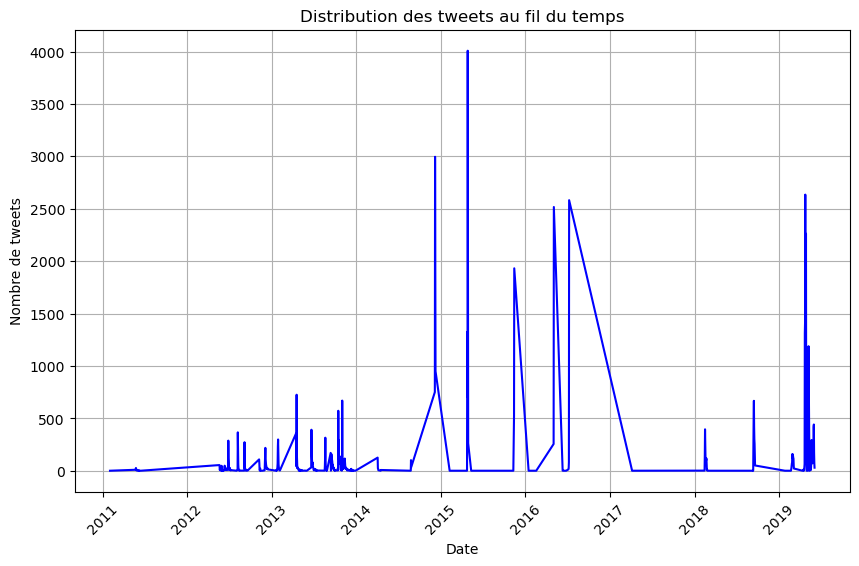

In [25]:
## Visualiser la distribution des tweets au fil du temps

# Graphique du nombre de tweets par jour
plt.figure(figsize=(10,6))
plt.plot(tweets_per_day['date'], tweets_per_day['tweet_count'], marker='', linestyle='-', color='b')
plt.title("Distribution des tweets au fil du temps")
plt.xlabel("Date")
plt.ylabel("Nombre de tweets")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Visualiser la distribution des mots au fil du 

C'est plutôt les tweets par mois

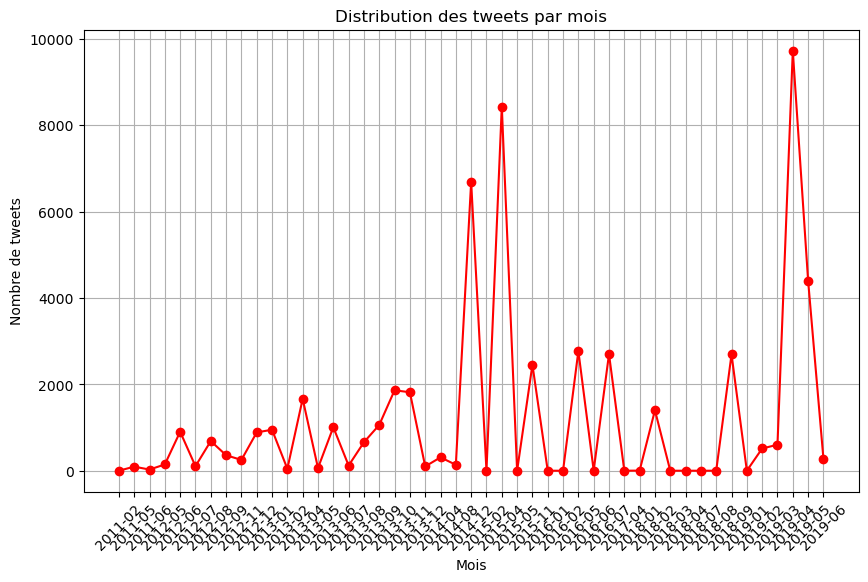

In [26]:
# Visualiser la distribution des mots au fil du temps

# 1. Extraire le mois de la date de création pour obtenir une vue mensuelle
final_db['month'] = final_db['date'].dt.to_period('M')

# 2. Compter le nombre de tweets par mois
tweets_per_month = final_db.groupby('month')['node_id_tweet'].nunique().reset_index(name='tweet_count')

# 3. Créer un graphique montrant l'évolution des tweets par mois
plt.figure(figsize=(10,6))
plt.plot(tweets_per_month['month'].astype(str), tweets_per_month['tweet_count'], marker='o', linestyle='-', color='r')
plt.title("Distribution des tweets par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de tweets")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Visualisation combinée : Mots et Tweets au fil du temps

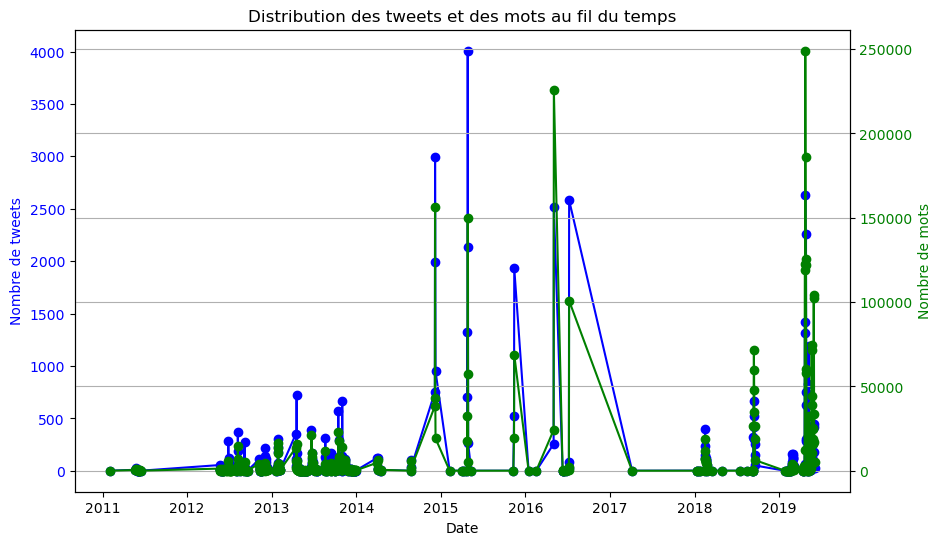

In [27]:
# Visualisation combinée : Mots et Tweets au fil du temps

# 1. Calculer la fréquence des mots par période de temps (par exemple, par jour)
final_db['word_counts'] = final_db['text_tweet'].apply(lambda x: len(x.split()))

# 2. Compter les mots par jour
words_per_day = final_db.groupby('date')['word_counts'].sum().reset_index(name='total_words')

# 3. Fusionner les deux DataFrames (tweets_per_day et words_per_day)
merged_df = pd.merge(tweets_per_day, words_per_day, on='date', how='left')

# 4. Graphique combiné des tweets et des mots au fil du temps
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(merged_df['date'], merged_df['tweet_count'], marker='o', color='b', label='Nombre de tweets')
ax1.set_xlabel('Date')
ax1.set_ylabel('Nombre de tweets', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['total_words'], marker='o', color='g', label='Nombre de mots')
ax2.set_ylabel('Nombre de mots', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title("Distribution des tweets et des mots au fil du temps")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Distribution du nombre de tweet par jour pour chaque type d'événement et pour chaque événement

### Nombre de tweet par jour par type d'évent

In [28]:
def tweet_count_for_event(final_db, event_type):
    # Filtrer les tweets pour le type d'événement donné
    df_event = final_db[final_db["eventType_event"] == event_type]

    # Supprimer les doublons pour ne pas compter plusieurs fois le même tweet
    df_event_unique = df_event.drop_duplicates(subset=["node_id_tweet", "month"])

    # Grouper par mois et compter les tweets
    tweets_per_month = df_event_unique.groupby("month").size().reset_index(name="tweet_count")

    return tweets_per_month


# 📌 Boucle pour appliquer la fonction à tous les eventType_event
event_tweet_data = {}
for event in final_db["eventType_event"].unique():
    var_name = f"df_{event}_tweet"
    globals()[var_name] = tweet_count_for_event(final_db, event)


In [29]:
final_db["eventType_event"].unique()

array(['wildfire', 'earthquake', 'flood', 'typhoon', 'shooting',
       'bombing'], dtype=object)

In [30]:
print(df_flood_tweet)
# print(df_wildfire_tweet)
# print(df_earthquake_tweet)
# print(df_typhoon_tweet)
# print(df_shooting_tweet)
# print(df_bombing_tweet)


      month  tweet_count
0   2011-02            1
1   2012-08          688
2   2013-01          950
3   2013-02           46
4   2013-06         1008
5   2013-07          121
6   2013-08          661
7   2013-09         1061
8   2013-10            2
9   2016-01            1
10  2018-01            1
11  2018-07            1
12  2019-02          310
13  2019-03          420
14  2019-04         2537


### Distribution (graph) pour les 6 types d'évenement

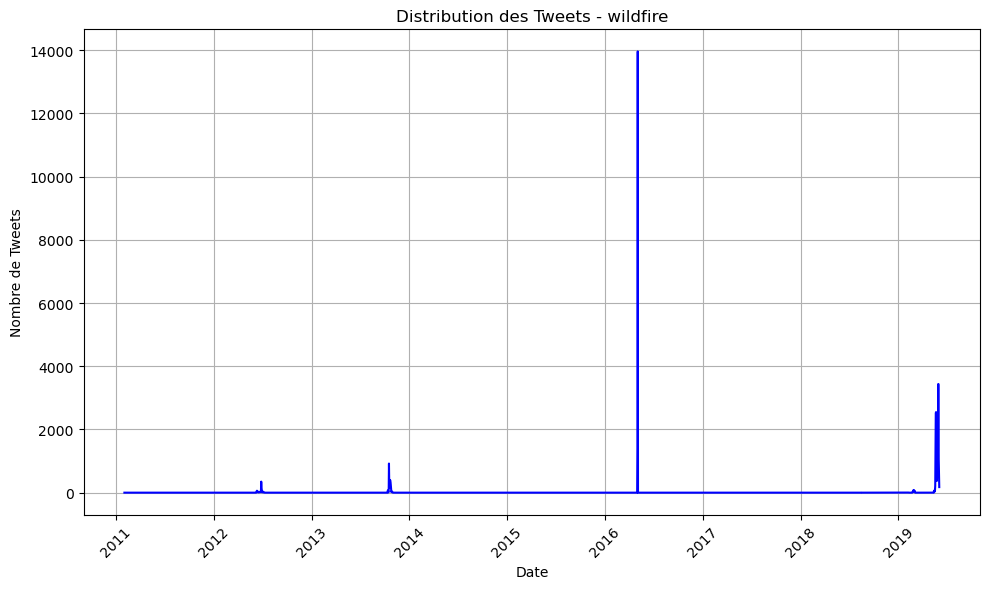

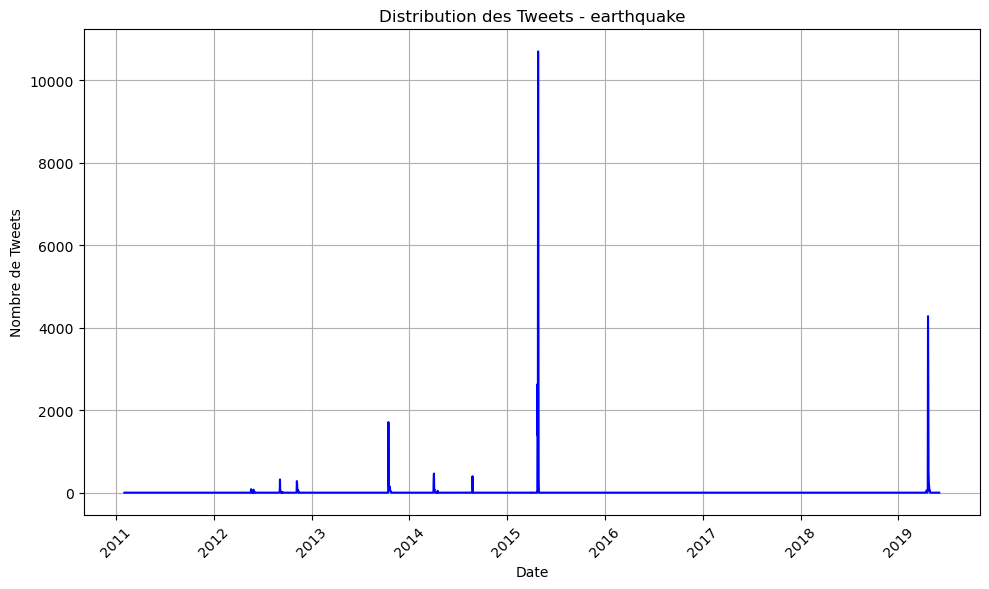

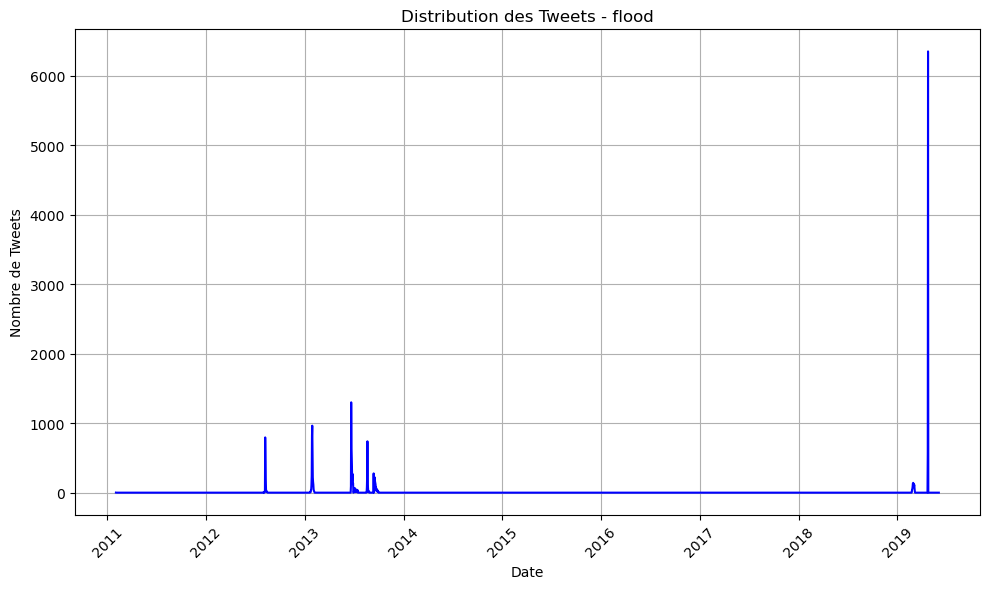

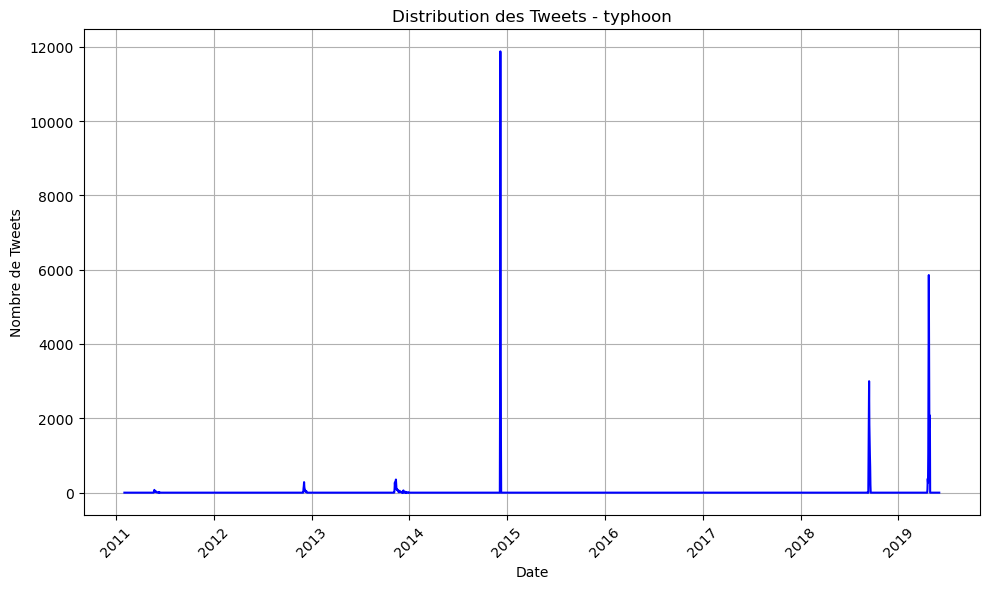

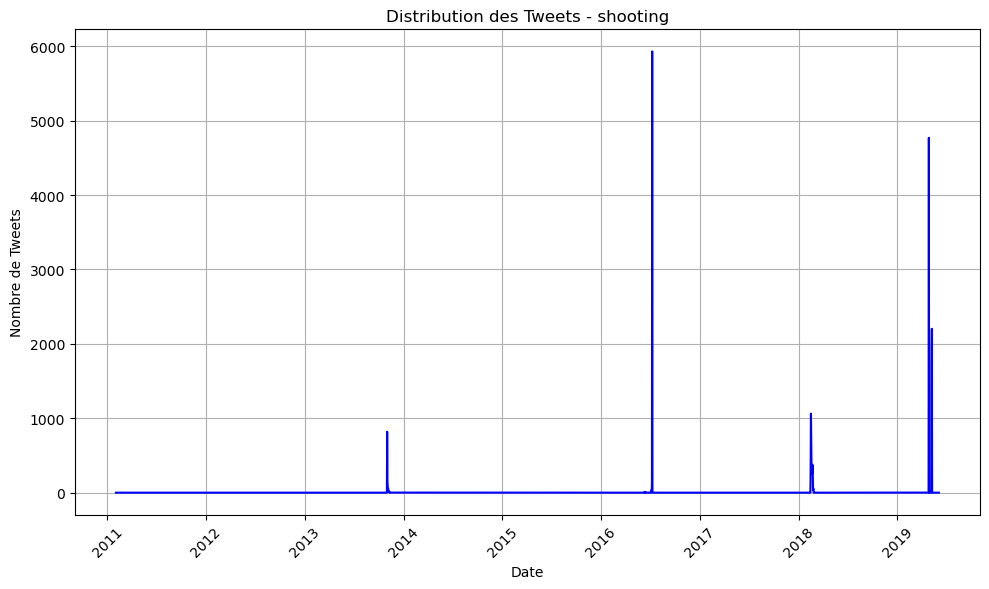

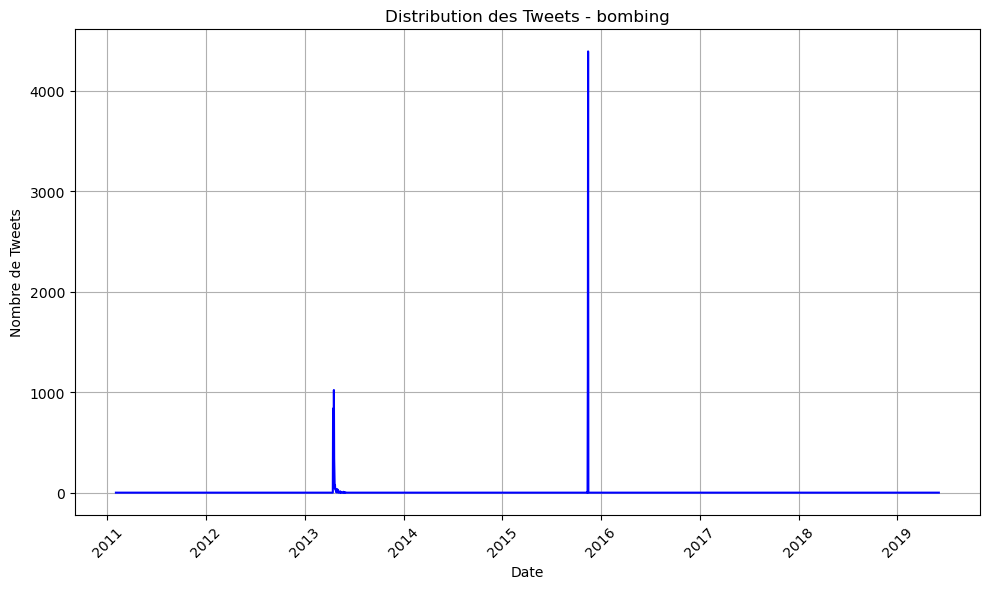

In [31]:
# Définir la plage de dates complète
date_range = pd.date_range(final_db['date'].min(), final_db['date'].max(), freq='D')

# Récupérer les types d'événements uniques
event_types = final_db['eventType_event'].unique()

# Boucle sur chaque type d'événement
for event in event_types:
    # Filtrer les tweets pour le type d'événement actuel
    df_event = final_db[final_db['eventType_event'] == event]

    # Compter les tweets par jour pour ce type d'événement
    tweet_count_per_day = df_event.groupby('date').size()

    # Réindexer pour inclure toutes les dates avec des 0 là où il n'y a pas de tweets
    tweet_count_per_day = tweet_count_per_day.reindex(date_range, fill_value=0)

    # Tracer le graphique
    plt.figure(figsize=(10, 6))
    plt.plot(tweet_count_per_day.index, tweet_count_per_day.values, marker='', linestyle='-', color='b')
    plt.title(f"Distribution des Tweets - {event}")
    plt.xlabel("Date")
    plt.ylabel("Nombre de Tweets")
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotation des dates pour meilleure lisibilité
    plt.tight_layout()

# Afficher le graphique
plt.show()


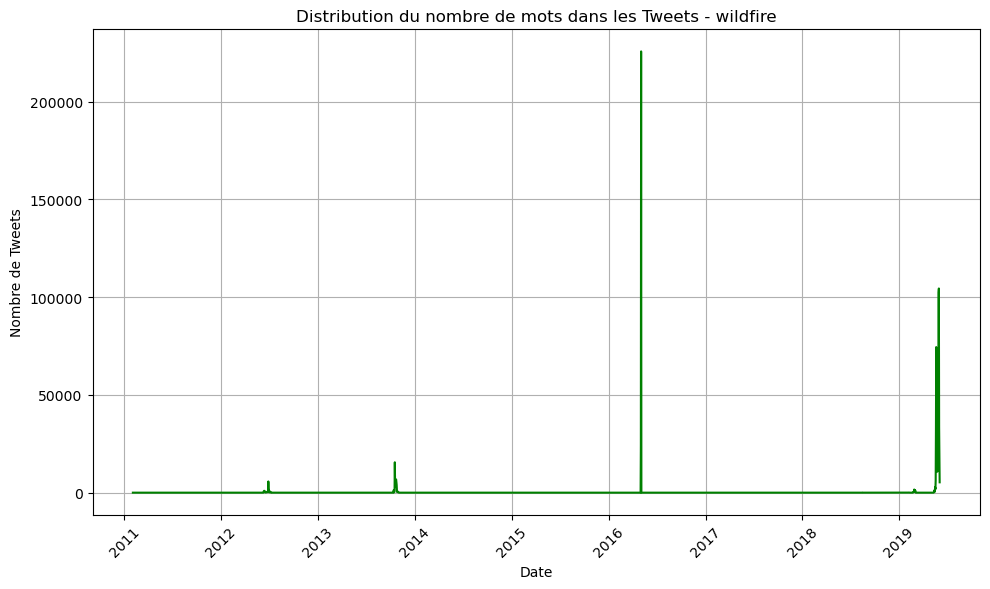

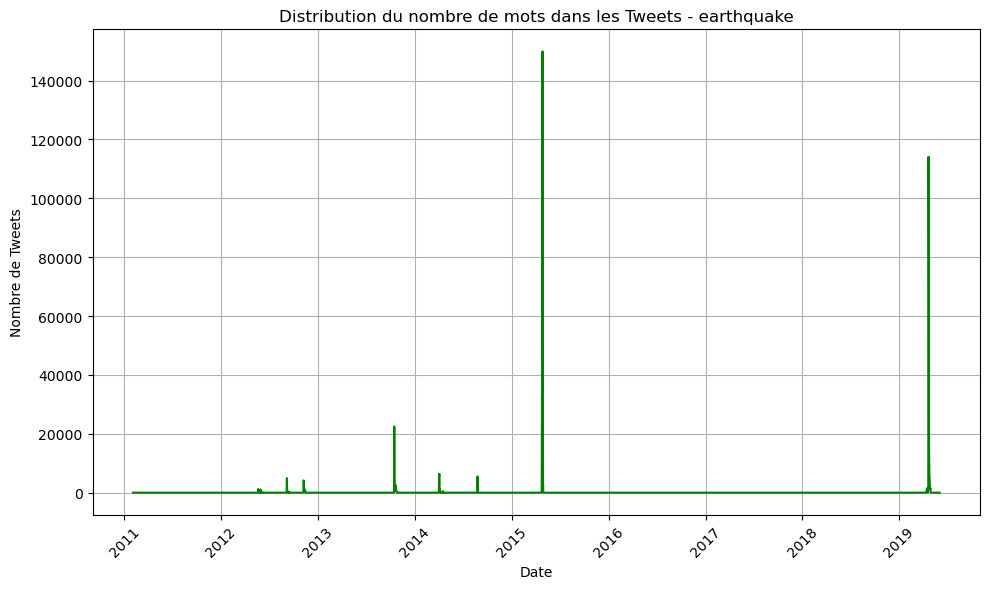

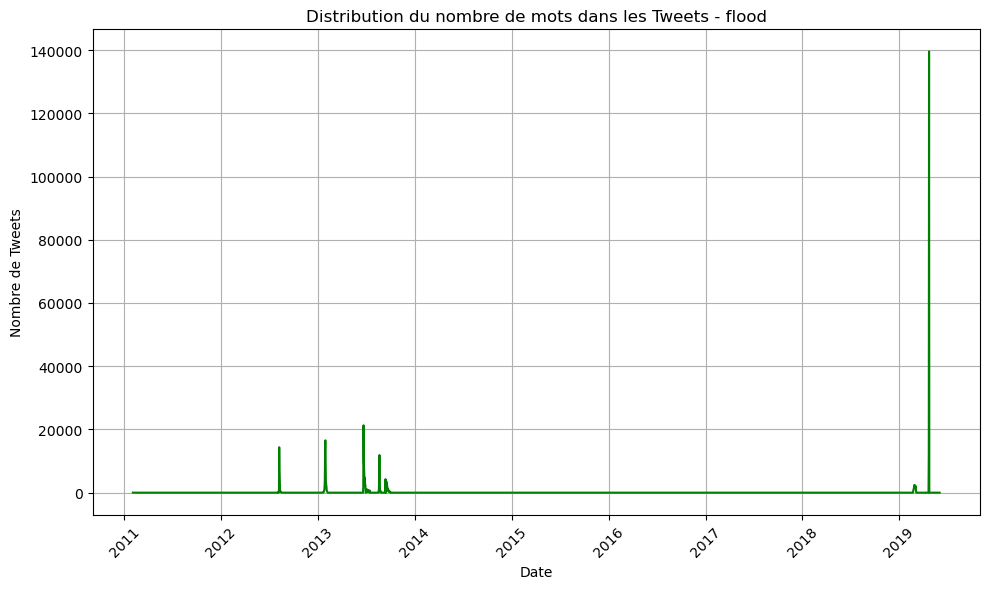

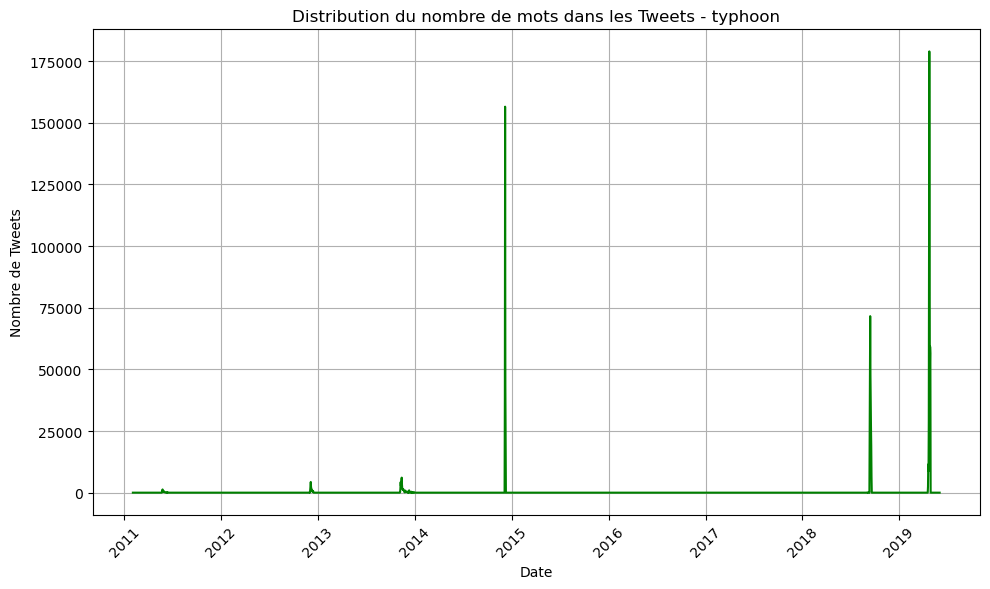

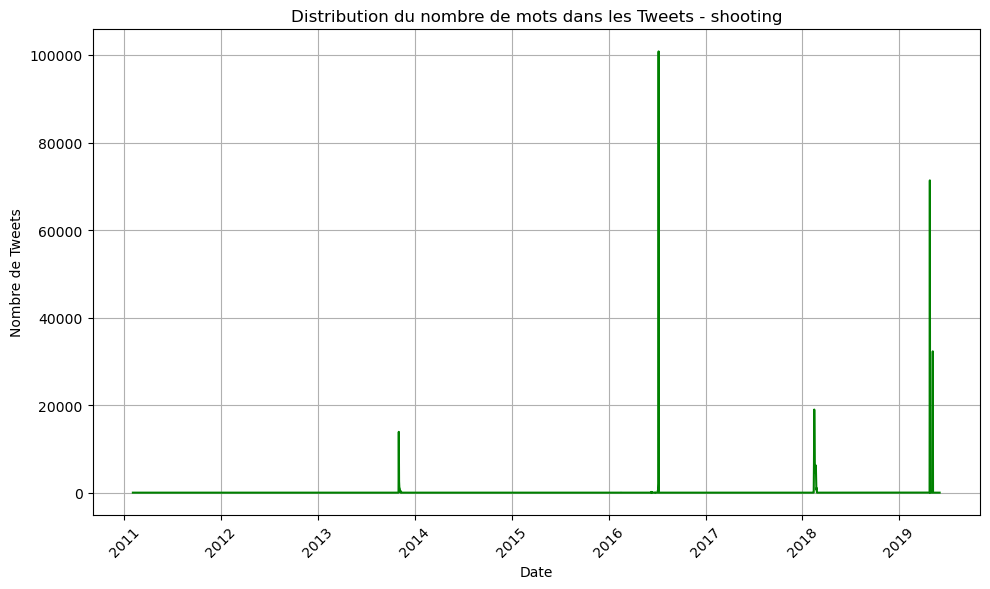

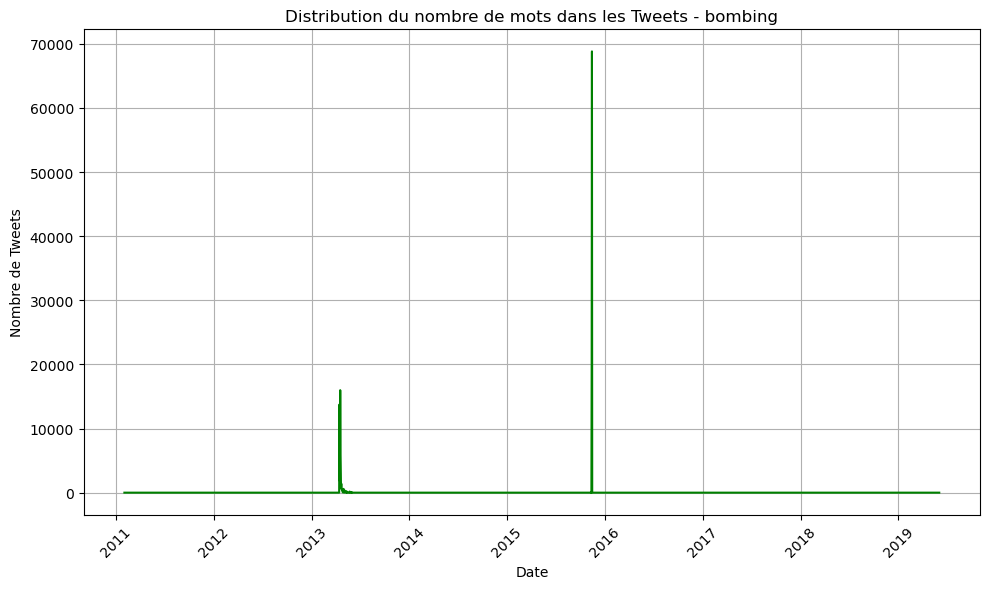

In [32]:
# Définir la plage de dates complète
date_range = pd.date_range(final_db['date'].min(), final_db['date'].max(), freq='D')

# Récupérer les types d'événements uniques
event_types = final_db['eventType_event'].unique()

# Boucle sur chaque type d'événement
for event in event_types:
    # Filtrer les tweets pour le type d'événement actuel
    df_event = final_db[final_db['eventType_event'] == event]

    # Compter le nombre total de mots par jour
    words_per_day = df_event.groupby('date')['word_counts'].sum().reindex(date_range, fill_value=0)

    # Tracer le graphique
    plt.figure(figsize=(10, 6))
    plt.plot(words_per_day.index, words_per_day.values, marker='', linestyle='-', color='g')
    plt.title(f"Distribution du nombre de mots dans les Tweets - {event}")
    plt.xlabel("Date")
    plt.ylabel("Nombre de Tweets")
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotation des dates pour meilleure lisibilité
    plt.tight_layout()

# Afficher le graphique
plt.show()



### Pareil en graph intéractif

In [33]:
import plotly.graph_objects as go

# Définir la plage de dates complète
date_range = pd.date_range(final_db['date'].min(), final_db['date'].max(), freq='D')

# Récupérer les types d'événements uniques
event_types = final_db['eventType_event'].unique()

# Création des figures pour chaque type d'événement
for event in event_types:
    # Filtrer les tweets pour le type d'événement actuel
    df_event = final_db[final_db['eventType_event'] == event]

    # Compter les tweets par jour pour ce type d'événement
    tweet_count_per_day = df_event.groupby('date').size()

    # Réindexer pour inclure toutes les dates avec des 0 là où il n'y a pas de tweets
    tweet_count_per_day = tweet_count_per_day.reindex(date_range, fill_value=0)

    # Créer un graphique interactif avec Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=tweet_count_per_day.index,
        y=tweet_count_per_day.values,
        mode='lines',  # Affiche à la fois les points et la ligne
        line=dict(color='blue'),
        marker=dict(size=6),
        hoverinfo='x+y',  # Affiche la date et le nombre de tweets au survol
        name=event
    ))

    # Mise en forme du graphique
    fig.update_layout(
        title=f"Distribution des Tweets - {event}",
        xaxis_title="Date",
        yaxis_title="Nombre de Tweets",
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        hovermode="x unified",  # Affichage fluide des valeurs lors du survol
        template="plotly_white"  # Style propre et lisible
    )

    # Afficher le graphique interactif
    fig.show()


### Distribution (graph) pour les 25 évenements

C:\Users\zapat\AppData\Local\Temp\ipykernel_16936\1095729981.py:26: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



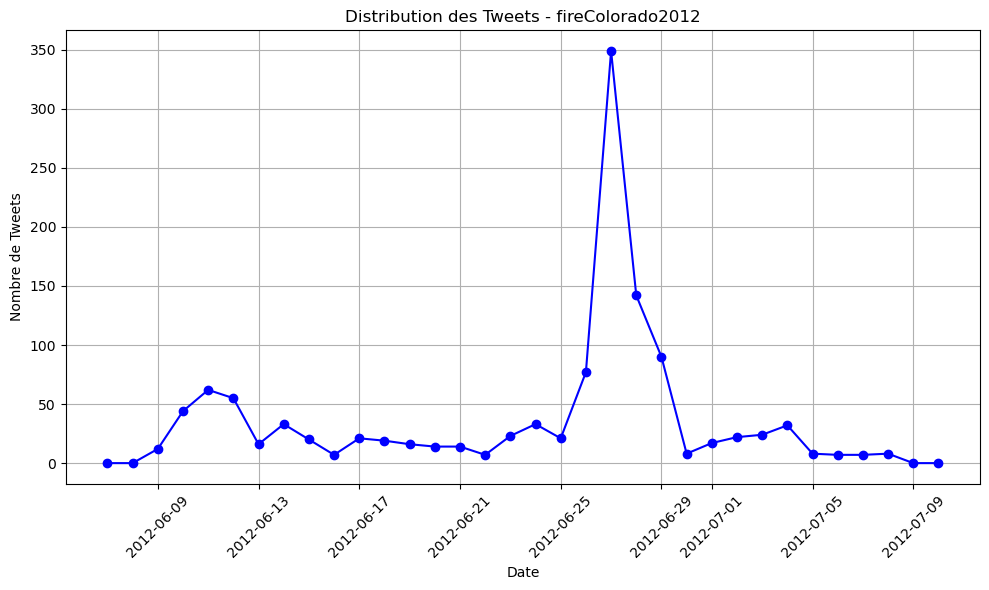

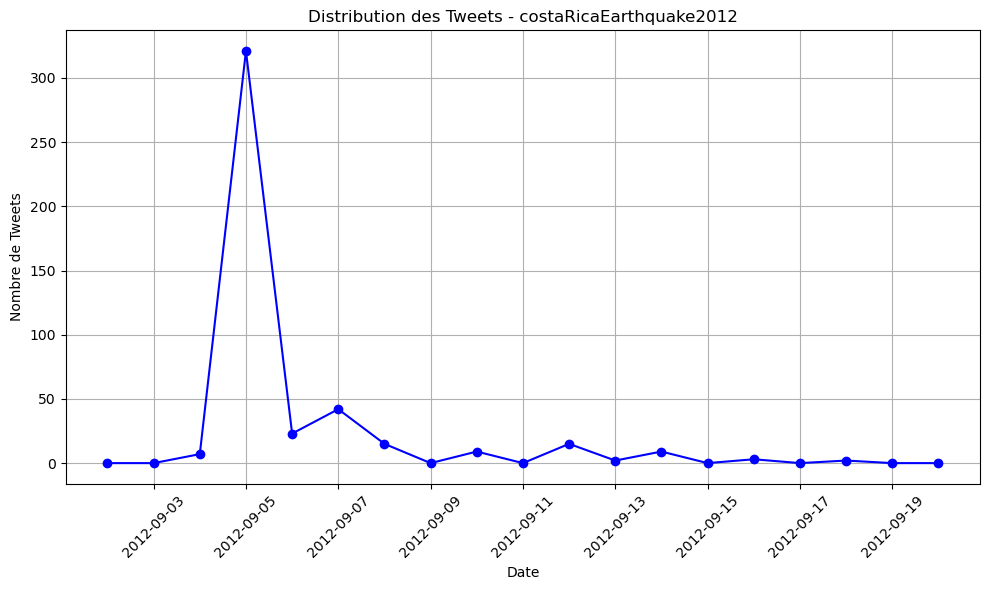

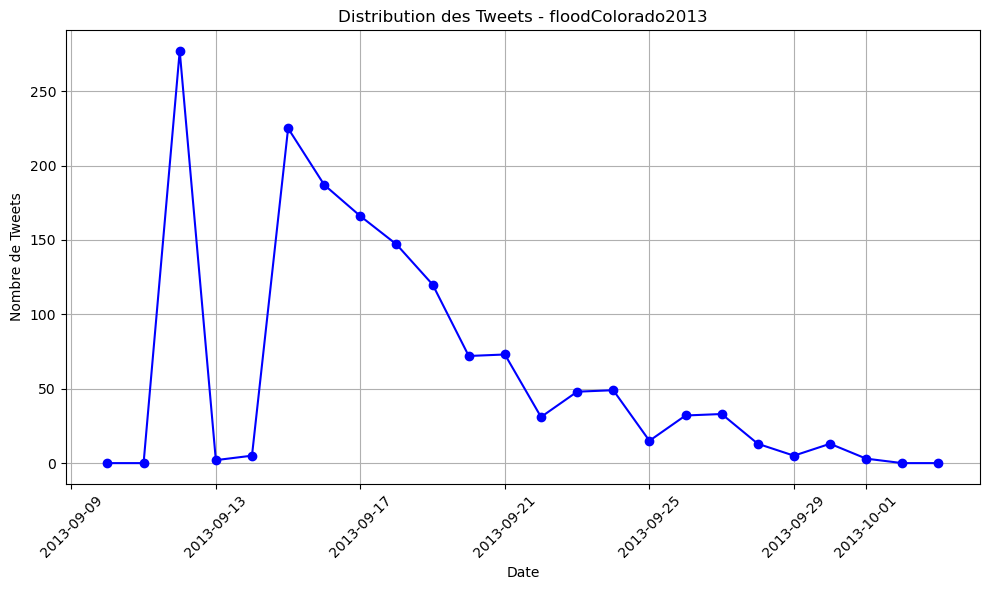

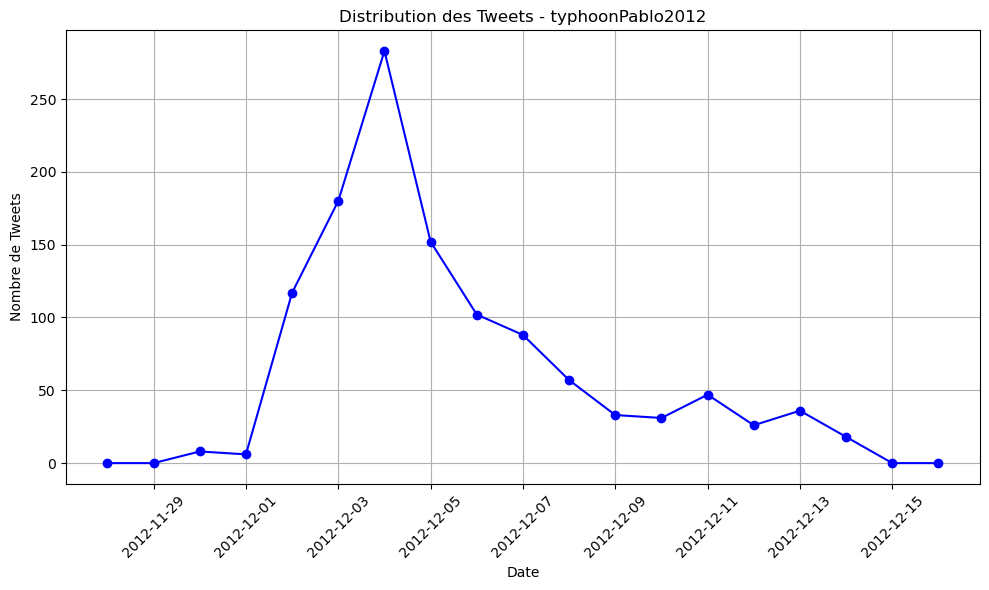

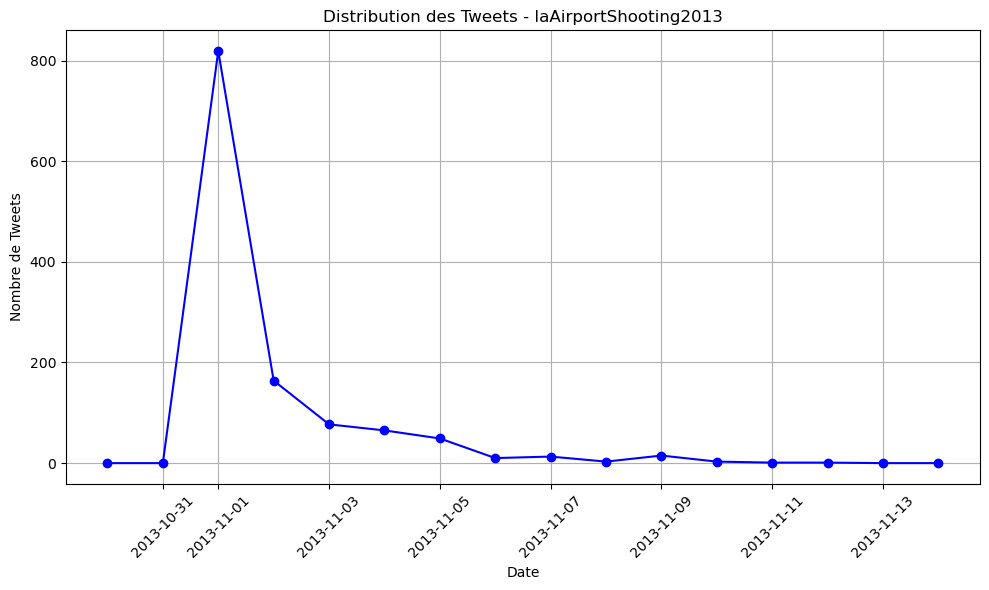

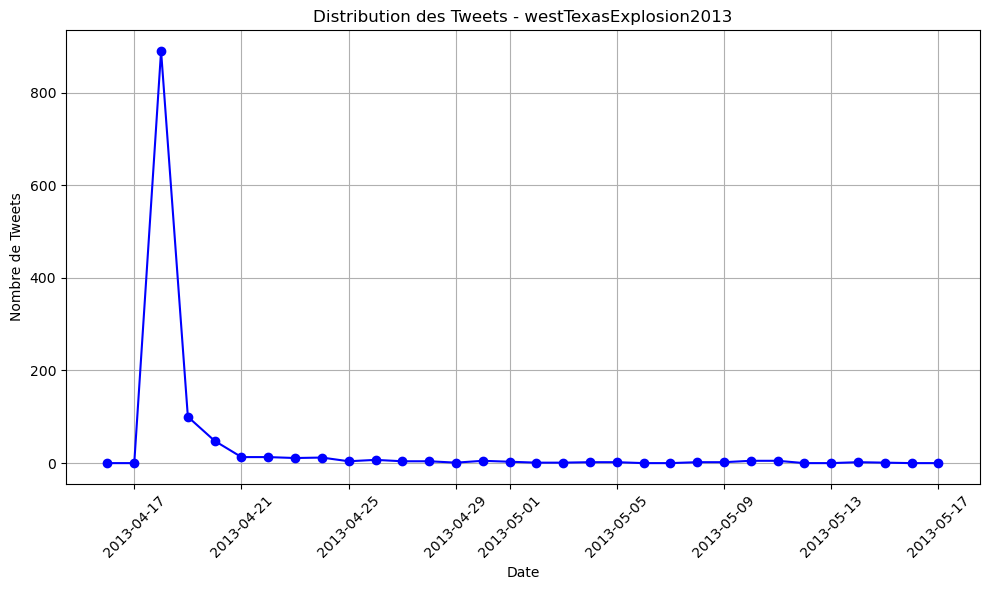

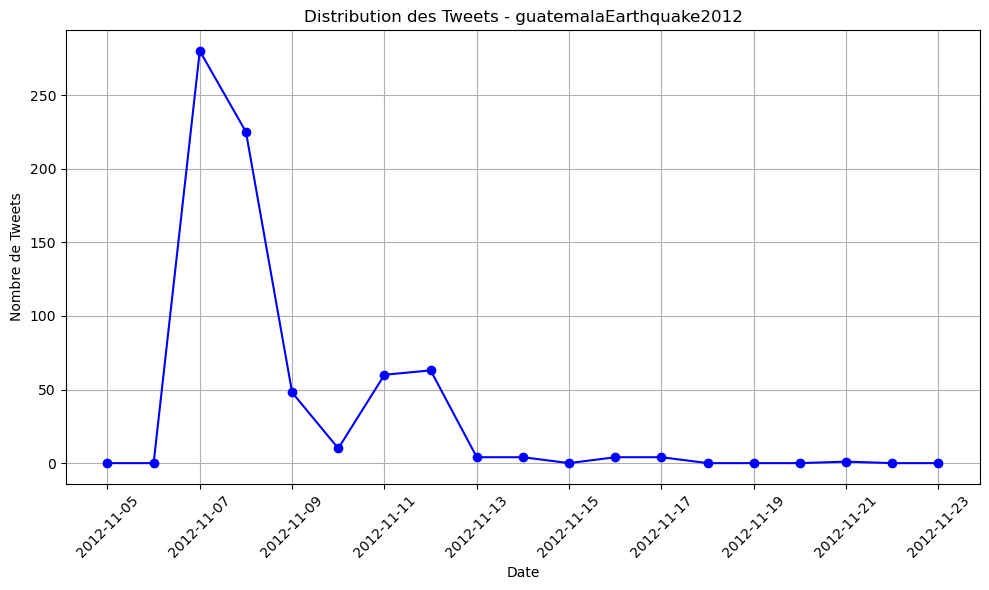

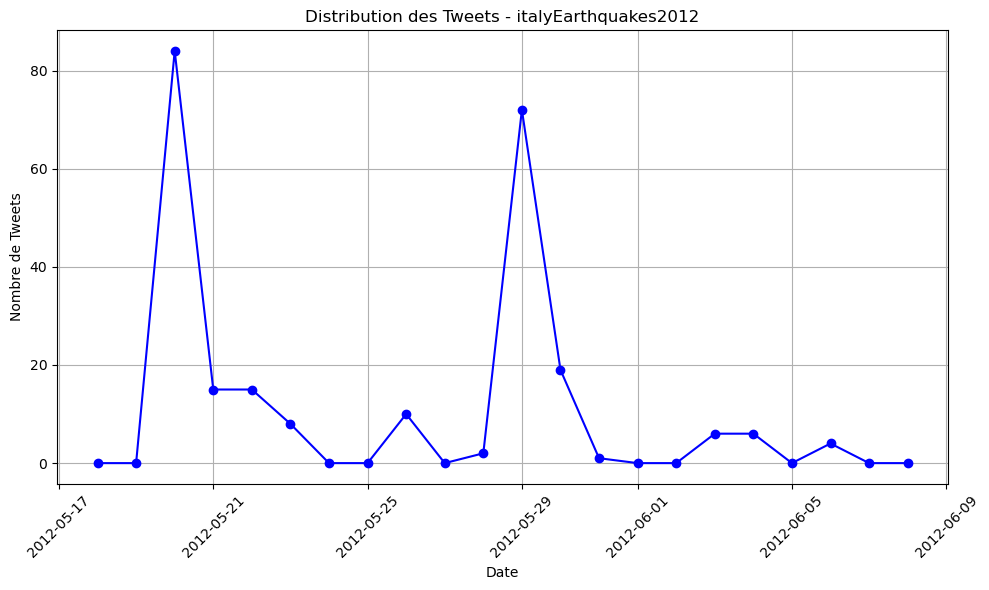

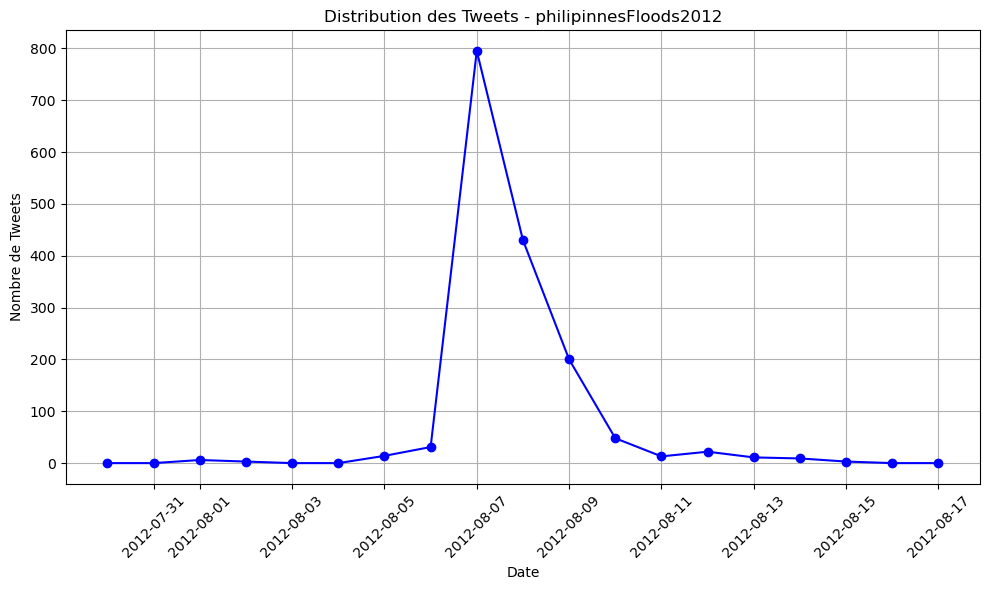

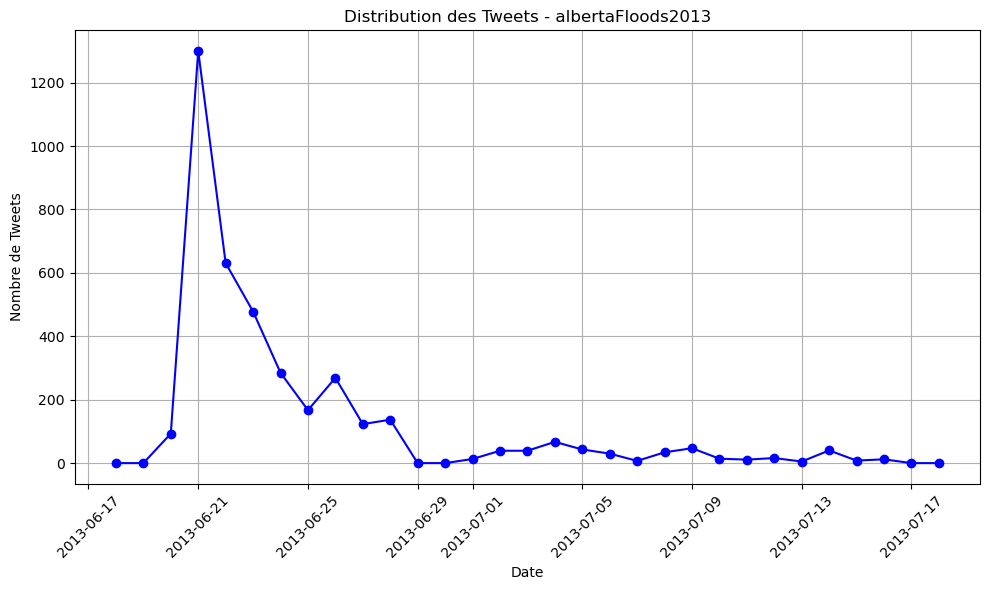

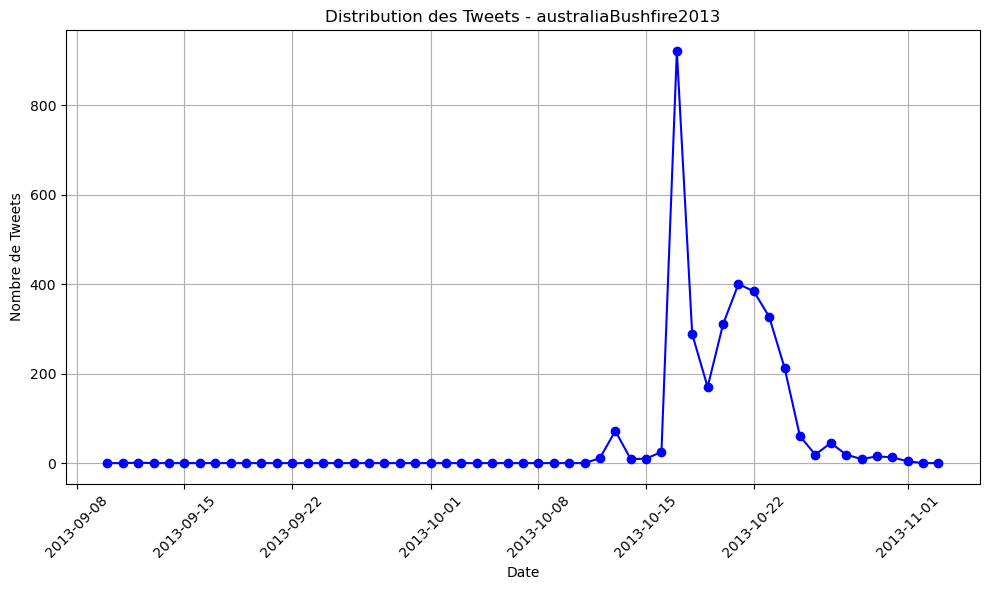

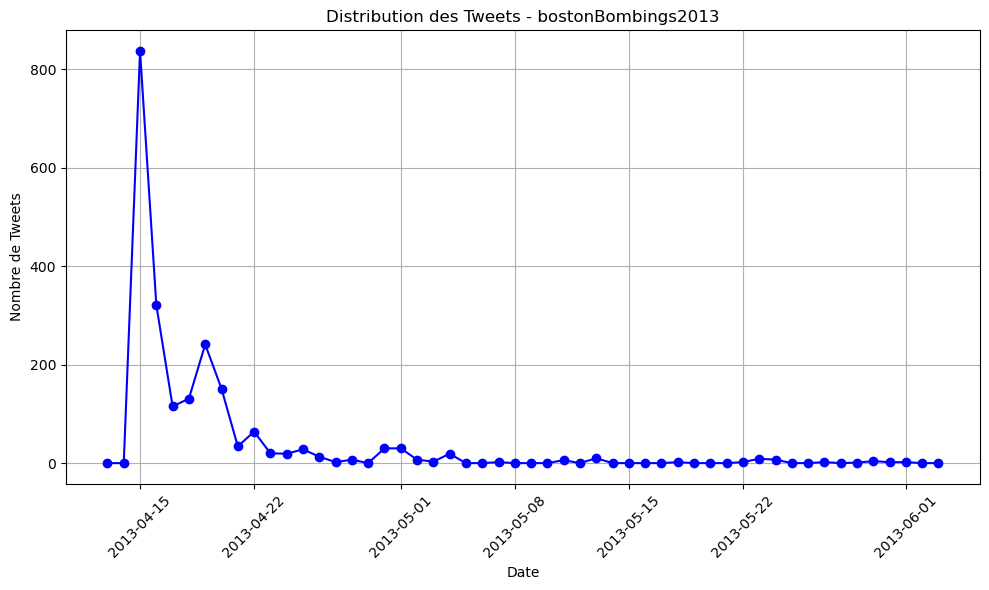

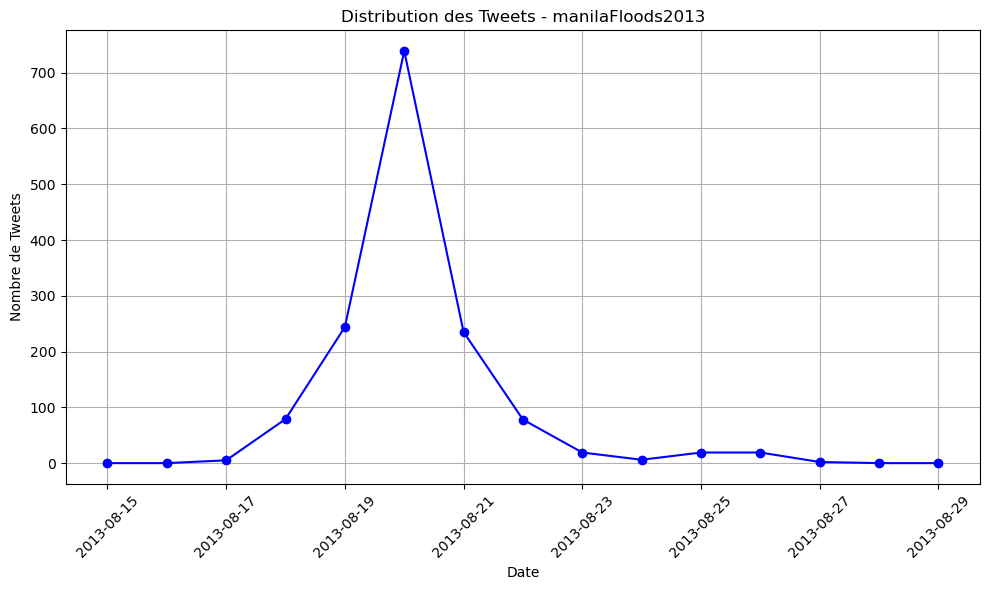

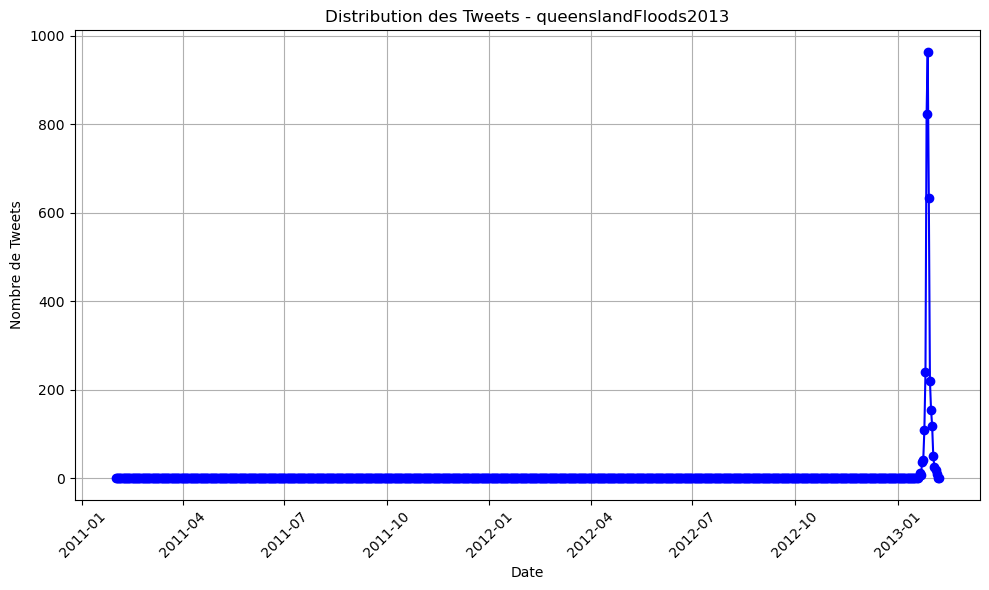

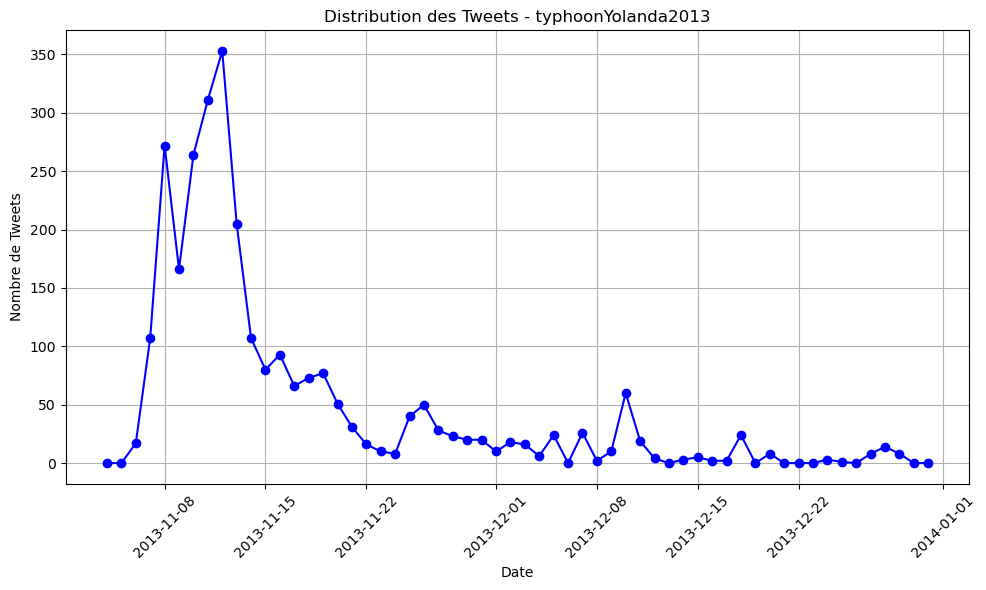

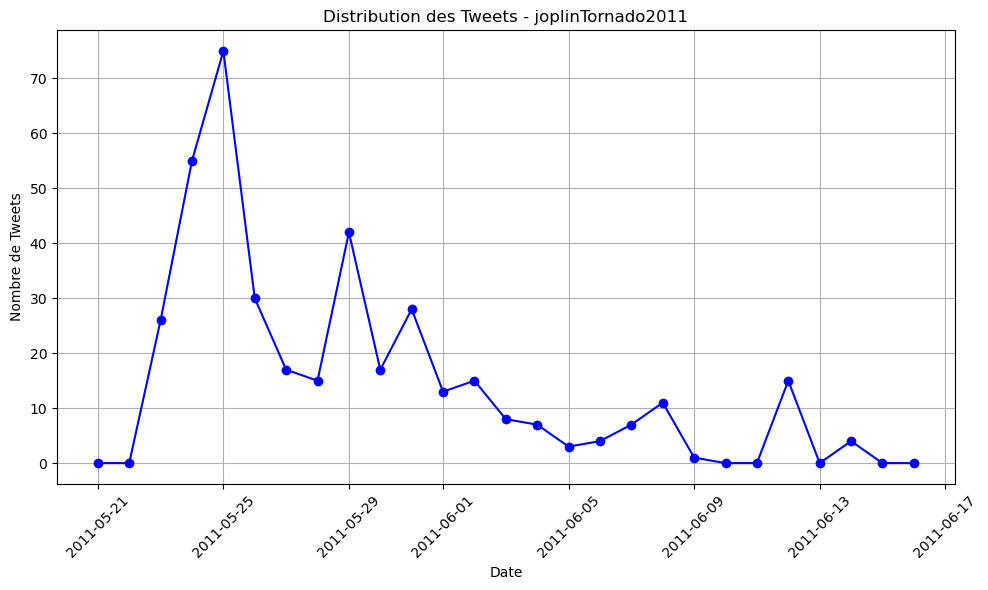

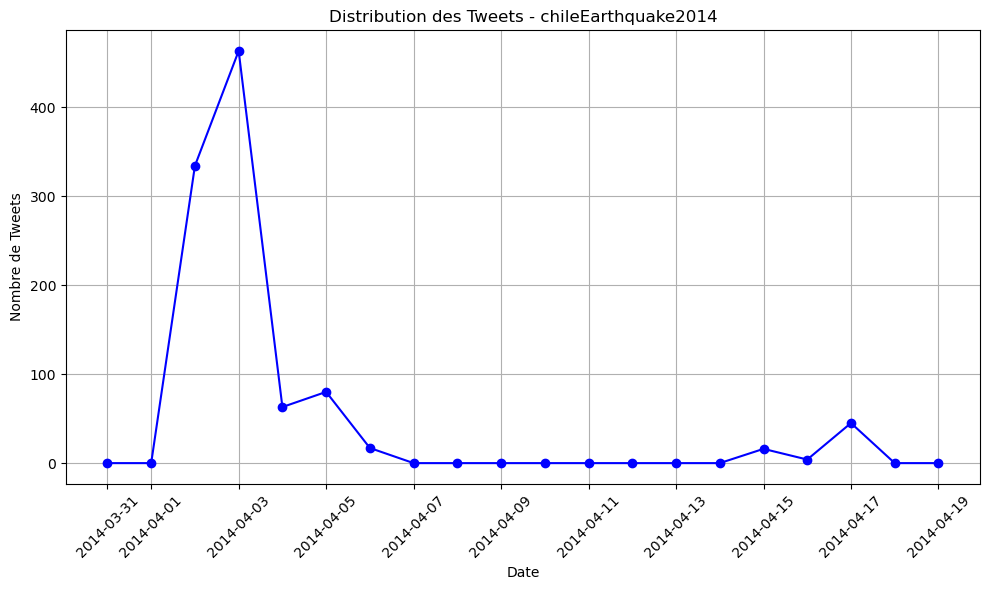

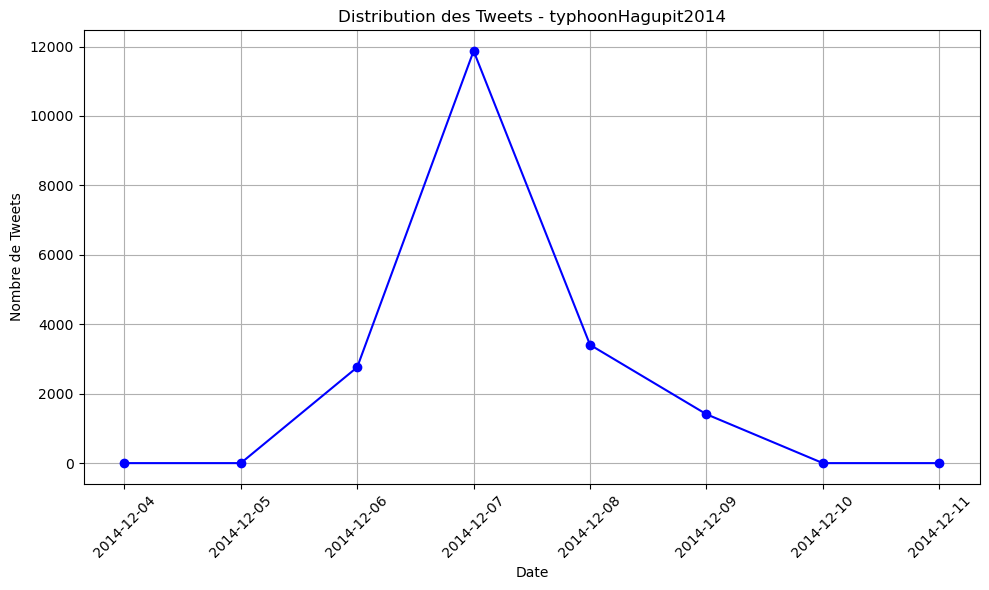

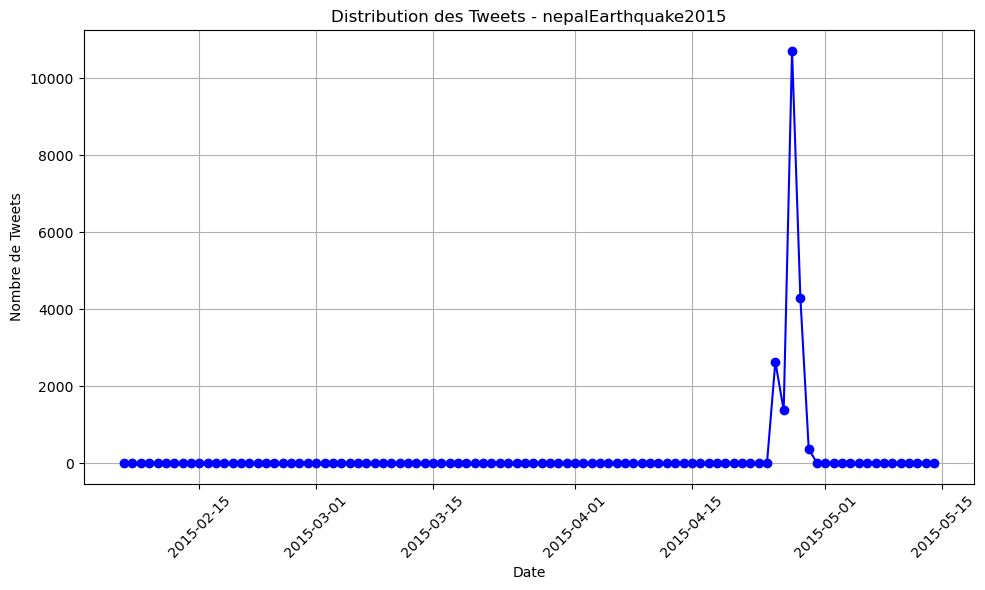

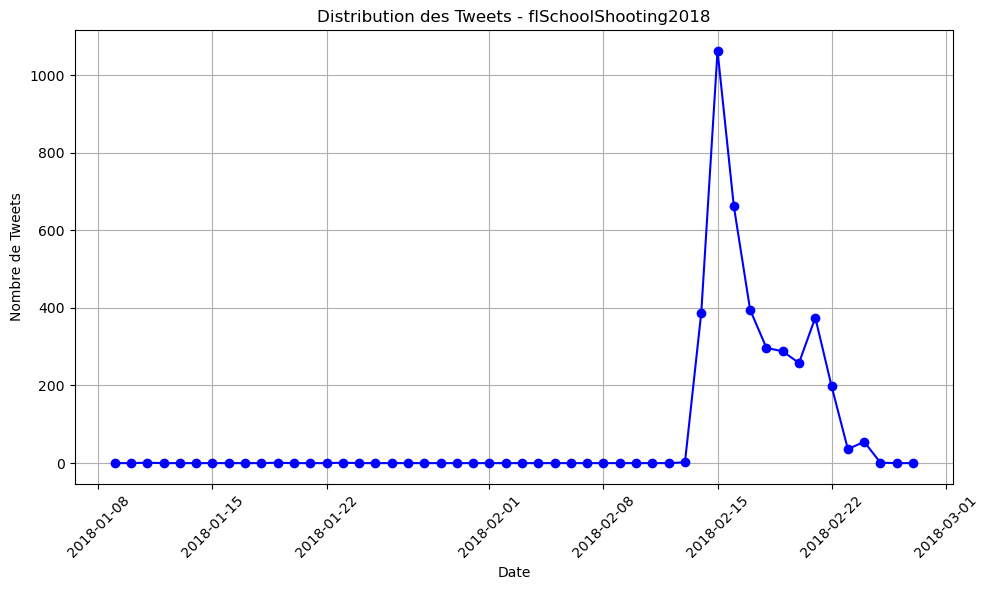

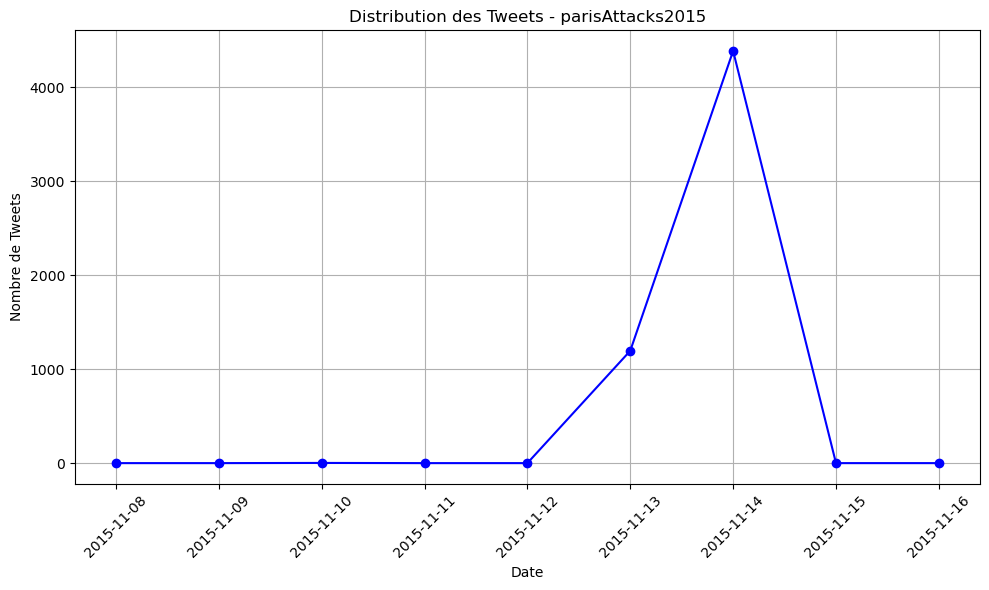

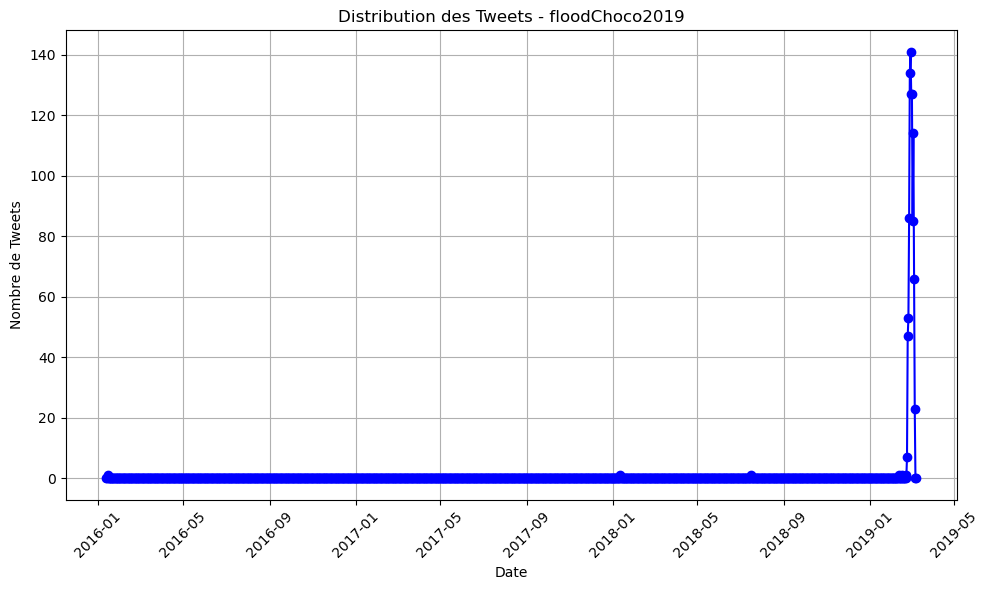

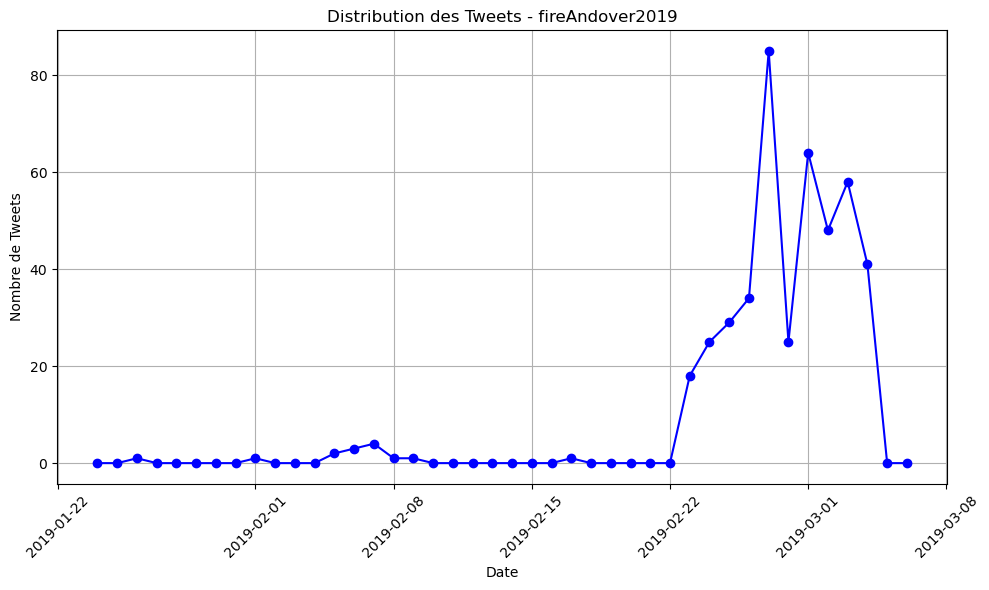

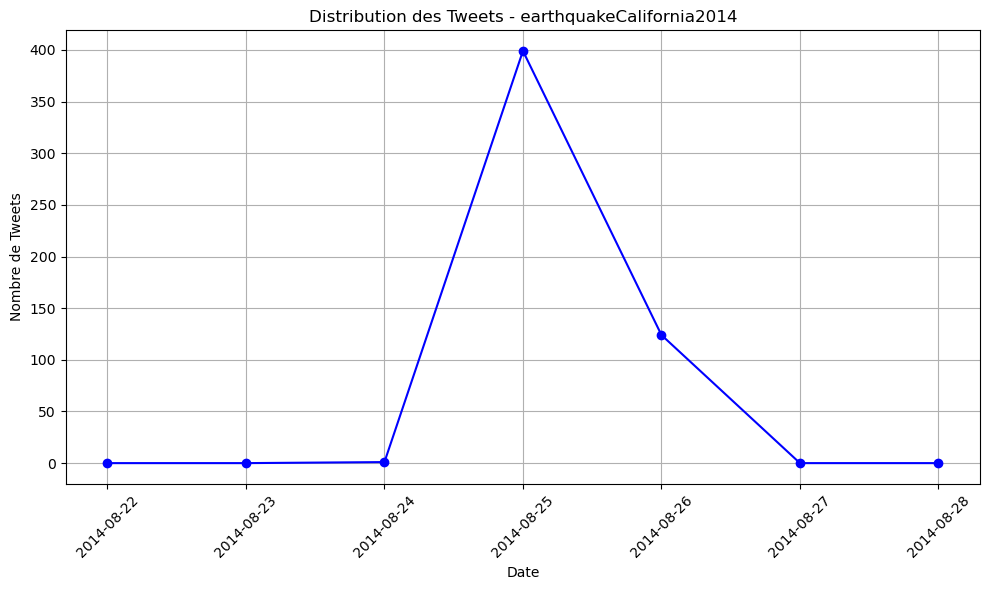

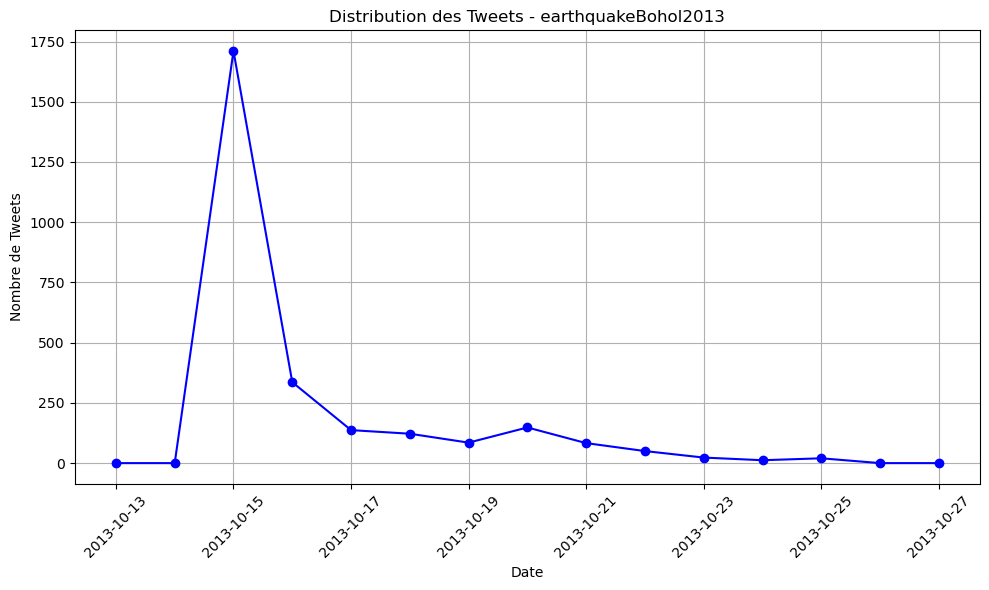

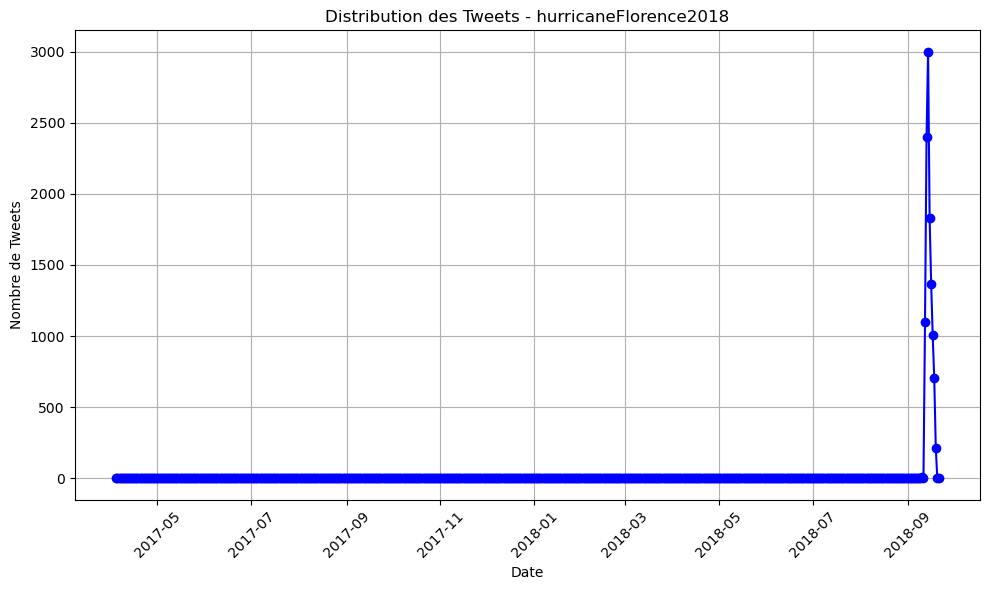

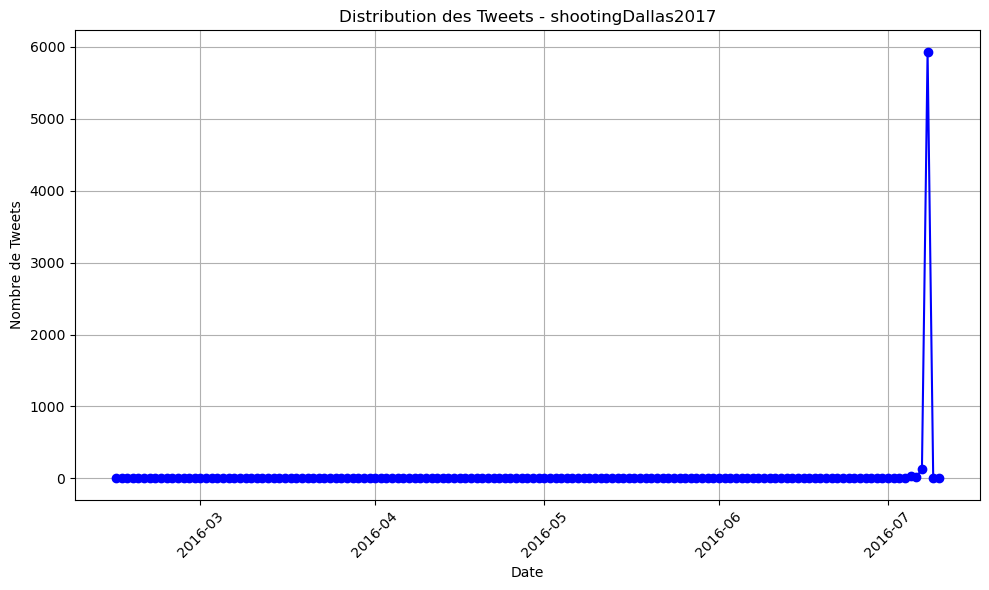

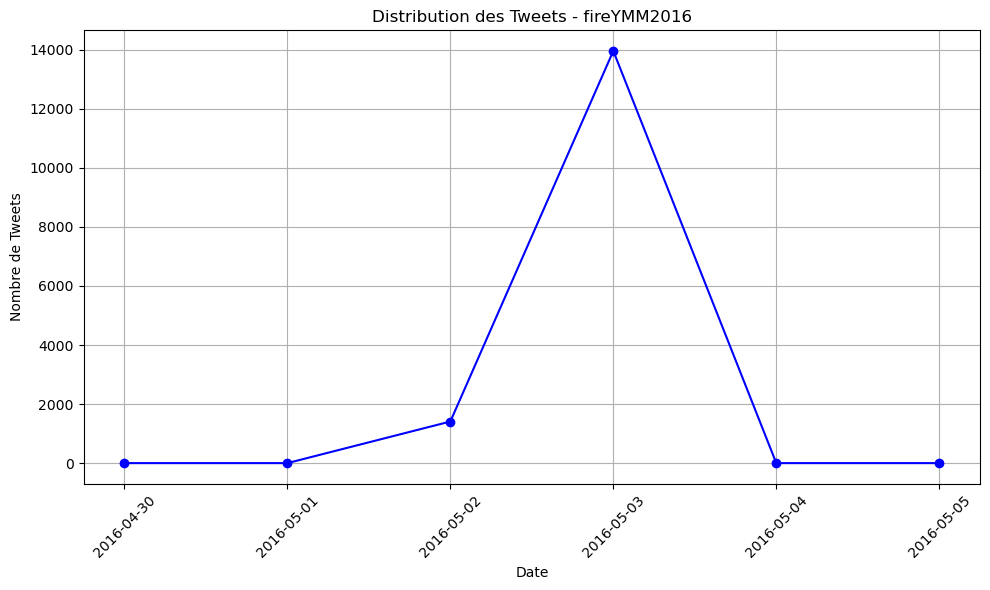

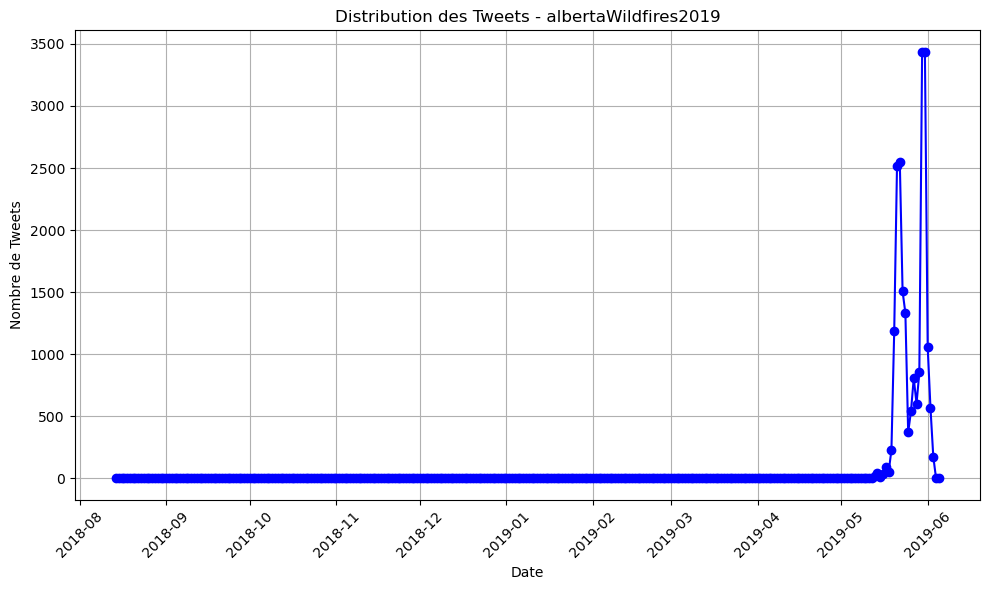

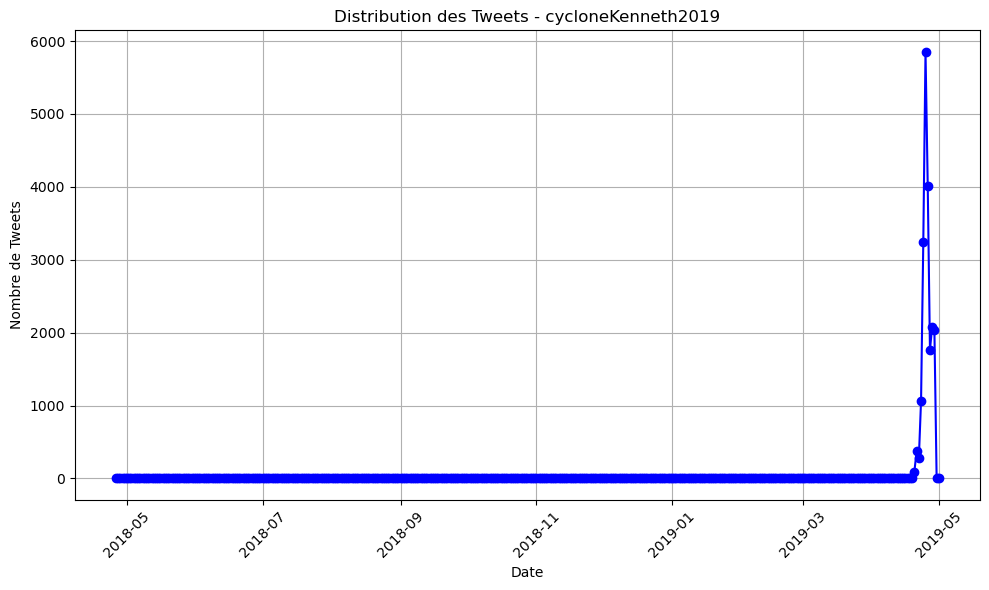

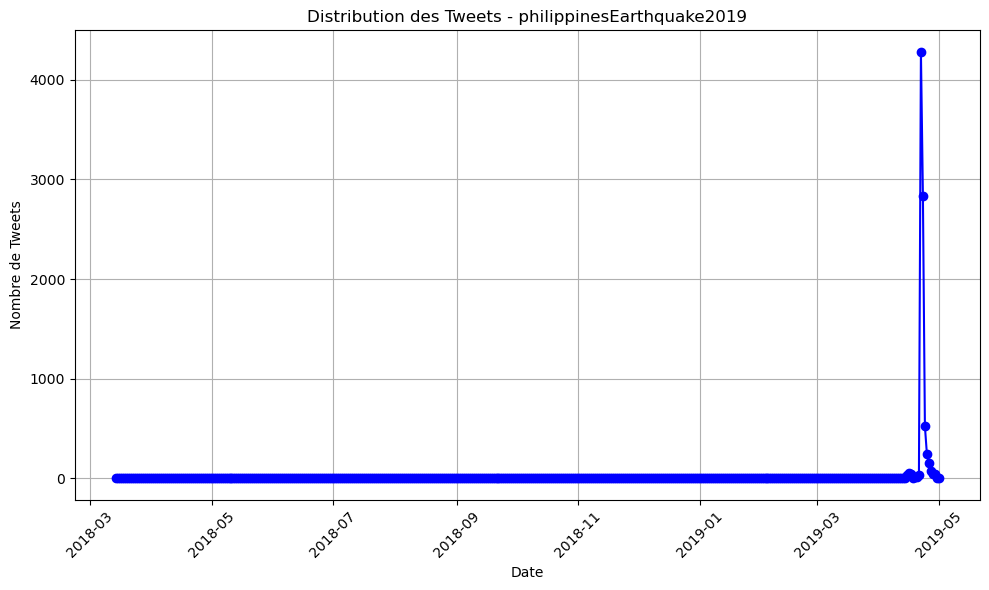

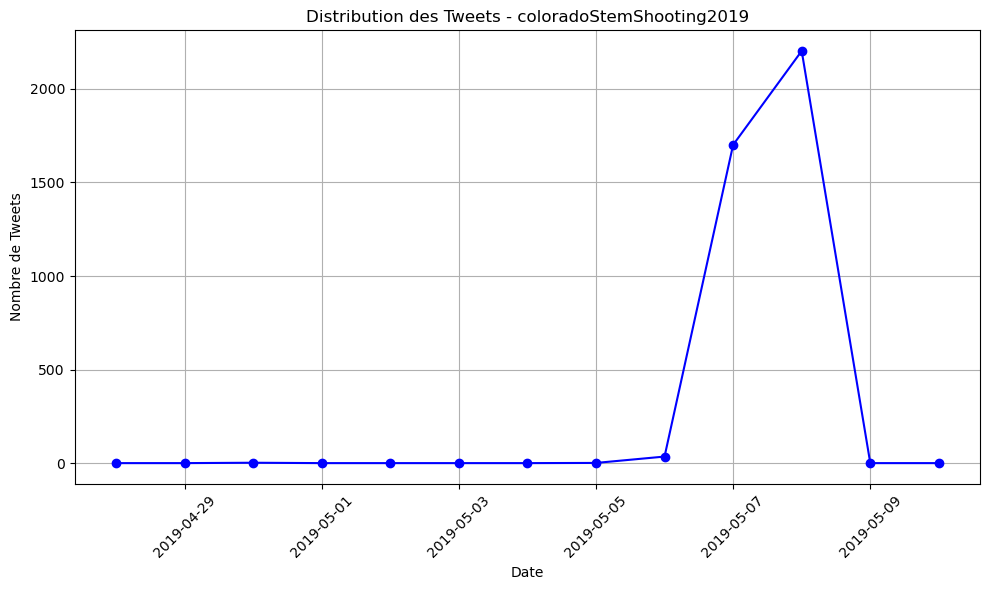

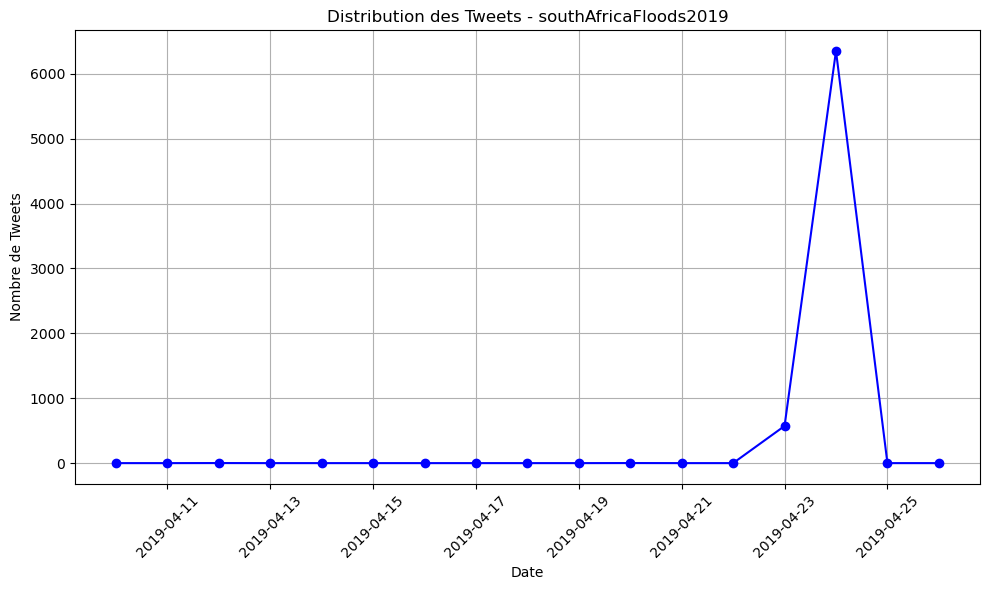

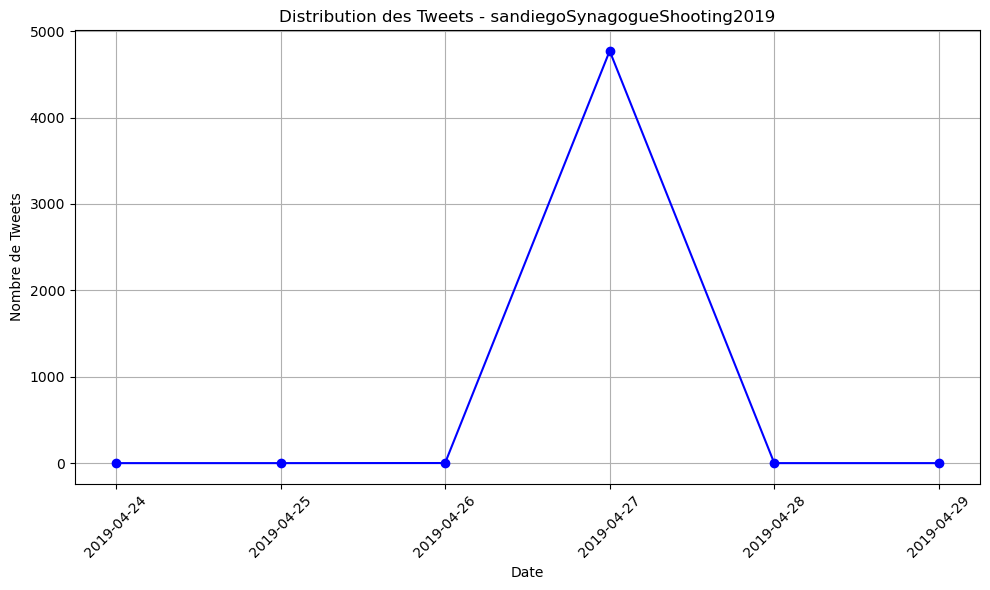

In [34]:
# Récupérer les types d'événements uniques
event_types = final_db['id_event_y'].unique()

# Boucle sur chaque type d'événement
for event in event_types:
    # Filtrer les tweets pour le type d'événement actuel
    df_event = final_db[final_db['id_event_y'] == event]

    # Trouver la date minimale et maximale des tweets
    date_min = df_event['date'].min() - pd.Timedelta(days=2)  # 2 jours avant
    date_max = df_event['date'].max() + pd.Timedelta(days=2)  # 2 jours après

    # Définir la nouvelle plage de dates complète avec 2 jours en plus
    date_range = pd.date_range(date_min, date_max, freq='D')
    # Définir la plage de dates complète
    # date_range = pd.date_range(df_event['DATE'].min(), df_event['DATE'].max(), freq='D')


    # Compter les tweets par jour pour ce type d'événement
    tweet_count_per_day = df_event.groupby('date').size()

    # Réindexer pour inclure toutes les dates avec des 0 là où il n'y a pas de tweets
    tweet_count_per_day = tweet_count_per_day.reindex(date_range, fill_value=0)

    # Tracer le graphique
    plt.figure(figsize=(10, 6))
    plt.plot(tweet_count_per_day.index, tweet_count_per_day.values, marker='o', linestyle='-', color='b')
    plt.title(f"Distribution des Tweets - {event}")
    plt.xlabel("Date")
    plt.ylabel("Nombre de Tweets")
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotation des dates pour meilleure lisibilité
    plt.tight_layout()

# Afficher le graphique
plt.show()


Interactif :

In [35]:
import plotly.graph_objects as go

# Récupérer les types d'événements uniques
event_types = final_db['id_event_y'].unique()

# Création des figures pour chaque type d'événement
for event in event_types:
    # Filtrer les tweets pour le type d'événement actuel
    df_event = final_db[final_db['id_event_y'] == event]

    # Trouver la date minimale et maximale des tweets
    date_min = df_event['date'].min() - pd.Timedelta(days=2)  # 2 jours avant
    date_max = df_event['date'].max() + pd.Timedelta(days=2)  # 2 jours après

    # Définir la nouvelle plage de dates complète avec 2 jours en plus
    date_range = pd.date_range(date_min, date_max, freq='D')

    # Définir la plage de dates complète
    # date_range = pd.date_range(df_event['DATE'].min(), df_event['DATE'].max(), freq='D')

    # Compter les tweets par jour pour ce type d'événement
    tweet_count_per_day = df_event.groupby('date').size()

    # Réindexer pour inclure toutes les dates avec des 0 là où il n'y a pas de tweets
    tweet_count_per_day = tweet_count_per_day.reindex(date_range, fill_value=0)

    # Créer un graphique interactif avec Plotly
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=tweet_count_per_day.index,
        y=tweet_count_per_day.values,
        mode='lines',  # Affiche à la fois les points et la ligne
        line=dict(color='blue'),
        marker=dict(size=6),
        hoverinfo='x+y',  # Affiche la date et le nombre de tweets au survol
        name=event
    ))

    # Mise en forme du graphique
    fig.update_layout(
        title=f"Distribution des Tweets - {event}",
        xaxis_title="Date",
        yaxis_title="Nombre de Tweets",
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        hovermode="x unified",  # Affichage fluide des valeurs lors du survol
        template="plotly_white"  # Style propre et lisible
    )

    # Afficher le graphique interactif
    fig.show()


## Top 10 mots pour chaque type d'évévenement

In [36]:
final_db.columns

Index(['node_id_tweet', 'possibly_sensitive_tweet', 'created_at_tweet',
       'retweet_count_tweet', 'is_quote_status_tweet',
       'annotation_postPriority_tweet', 'favorite_count_tweet', 'text_tweet',
       'node_id_user', 'friends_count_user', 'isVerified_user',
       'screen_name_user', 'statuses_count_user', 'favourites_count_user',
       'followers_count_user', 'name_user', 'node_id_event', 'id_event_y',
       'eventType_event', 'node_id_hashtag', 'occurences_hashtag',
       'id_hashtag_y', 'node_id_category', 'id_category', 'date', 'year',
       'month', 'word_counts'],
      dtype='object')

In [37]:
# Dictionnaire pour stocker les tableaux de fréquences des mots par type d'événement
word_freq_by_event = {}

# Récupérer tous les types d'événements uniques
event_types = final_db['eventType_event'].unique()

# Boucle sur chaque type d'événement
for event in event_types:
    # Sélectionner les tweets correspondant à l'événement
    bd_selection = final_db[final_db['eventType_event'] == event]

    # Vérifier qu'il y a bien des tweets pour cet événement
    if not bd_selection.empty:
        # Utiliser CountVectorizer pour compter la fréquence des mots
        vectorizer = CountVectorizer(stop_words='english')  # Ignore les stop words
        X = vectorizer.fit_transform(bd_selection['text_tweet'])
        words = vectorizer.get_feature_names_out()

        # Convertir la matrice de mots en DataFrame
        word_count = np.array(X.sum(axis=0)).flatten()
        word_freq_df = pd.DataFrame({'word': words, 'count': word_count})

        # Trier par fréquence décroissante
        word_freq_df = word_freq_df.sort_values(by='count', ascending=False)

        # Stocker le DataFrame dans le dictionnaire avec le nom de l'événement
        word_freq_by_event[event] = word_freq_df

        # Afficher les 10 mots les plus fréquents pour cet événement
        print(f"\n🔹 Top 10 mots les plus fréquents pour l'événement : {event}")
        print(word_freq_df.head(10))




🔹 Top 10 mots les plus fréquents pour l'événement : wildfire
           word  count
7302      https  30048
15896   ymmfire  15241
1747    alberta  10846
15891       ymm  10307
1452     abfire   9990
15349  wildfire   9586
7091       high   6277
8735      level   5971
12342        rt   5410
13060     smoke   4970

🔹 Top 10 mots les plus fréquents pour l'événement : earthquake
                  word  count
7739        earthquake  15398
11054             http  13436
11055            https  11187
15828            nepal  11135
17564      philippines   5677
15843  nepalearthquake   4468
14358        magnitude   3974
18763            quake   2670
17441           people   2538
19985               rt   2215

🔹 Top 10 mots les plus fréquents pour l'événement : flood
           word  count
7261      https   7769
12562        rt   6739
7260       http   6543
5988     floods   4974
13436     south   3029
1578     africa   2868
5973      flood   2567
2564     bigwet   2378
5038     durban   2244
16

In [38]:
final_db.to_csv('final_db.csv', index=False, encoding='utf-8')

# B. Topics addressed in the tweets in the form of  word clusters built upon the k-top words based on their inverse document frequency in the corpus (i)

## Check la langue des tweets

In [39]:
#!pip install langid


In [40]:
import langid

In [41]:
def detect_language(text):
    return langid.classify(text)[0]  # Retourne le code de la langue détectée

final_db['lang'] = final_db['text_tweet'].apply(detect_language)

print(final_db['lang'].value_counts())


lang
en    172378
es      1667
fr       760
de       627
tl       443
it       401
nl       345
sw       344
pl       294
pt       235
id       231
da       187
zh       174
la       145
eo       137
rw       134
af       123
br       111
et       107
an        99
no        96
fi        95
ms        91
sl        86
mt        73
eu        66
lt        64
cs        56
mg        55
sv        54
hu        52
jv        51
zu        43
ht        35
oc        31
lv        30
nn        27
qu        25
ro        22
ca        21
cy        21
gl        20
lb        19
tr        19
hr        18
nb        18
ga        14
sk        12
xh        11
bs        10
sq         9
ar         8
ku         5
vi         5
vo         4
az         4
se         3
Name: count, dtype: int64


In [42]:
bd_clean = final_db[final_db['lang'] == 'en'].copy()

In [43]:
bd_clean.to_csv('bd_clean.csv', index=False, encoding='utf-8')

## TF-IDF

In [44]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zapat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zapat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [45]:
# 1️⃣ Charger les tweets (exemple avec un fichier CSV)
tweets = bd_clean["text_tweet"].astype(str).tolist()  
event_types = bd_clean["eventType_event"].tolist()  # Colonne contenant le type d'événement

In [46]:
# 2️⃣ Prétraitement des tweets
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Minuscule
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Supprimer URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Supprimer mentions et hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Supprimer ponctuation
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Stopwords + lemmatisation
    return " ".join(words)

tweets_clean = [preprocess_text(tweet) for tweet in tweets]

In [47]:
# 3️⃣ Vectorisation TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # On prend les 5000 mots les plus fréquents
X_tfidf = vectorizer.fit_transform(tweets_clean)

In [48]:
# 4️⃣ Réduction de dimension (facultatif mais utile)
svd = TruncatedSVD(n_components=100)  # Réduit à 100 dimensions
X_reduced = svd.fit_transform(X_tfidf)

In [49]:
# 5️⃣ Clustering avec K-Means
num_clusters = 5  # Nombre de clusters à ajuster
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
kmeans.fit(X_reduced)
labels = kmeans.labels_

c:\Users\zapat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\zapat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [50]:
# 6️⃣ Analyse des clusters
terms = vectorizer.get_feature_names_out()
clusters = {i: [] for i in range(num_clusters)}

for i, label in enumerate(labels):
    clusters[label].extend(tweets_clean[i].split())


🔹 Cluster 0 :
['rt', 'earthquake', 'wildfire', 'fire', 'alberta', 'nepal', 'abfire', 'people', 'flood', 'amp']

🔹 Cluster 1 :
['typhoon', 'philippine', 'hagupit', 'hit', 'rt', 'haiyan', 'earthquake', 'news', 'ruby', 'flee']

🔹 Cluster 2 :
['shooting', 'school', 'dallas', 'synagogue', 'injured', 'police', 'san', 'diego', 'people', 'poway']

🔹 Cluster 3 :
['mozambique', 'cyclone', 'kenneth', 'cyclonekenneth', 'hit', 'storm', 'tropical', 'landfall', 'cycloneidai', 'people']

🔹 Cluster 4 :
['ymmfire', 'ymm', 'fort', 'fire', 'rt', 'mcmurray', 'safe', 'rmwb', 'fortmcmurray', 'evacuation']


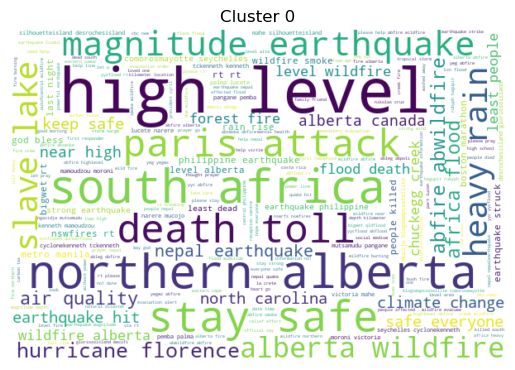

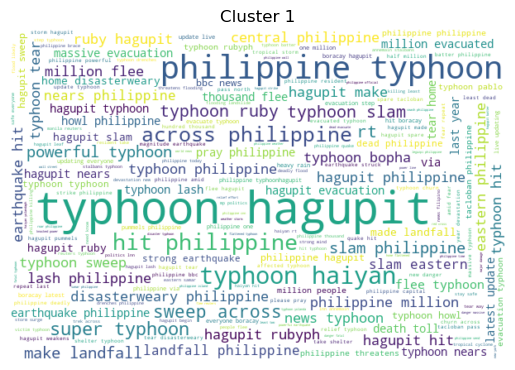

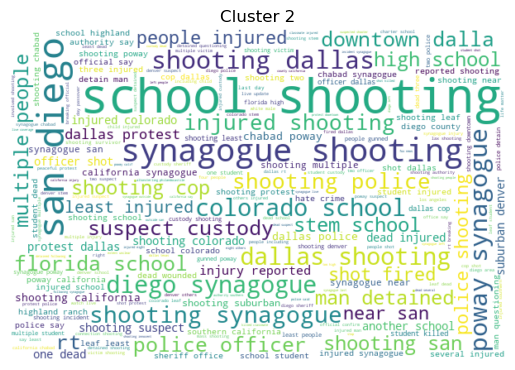

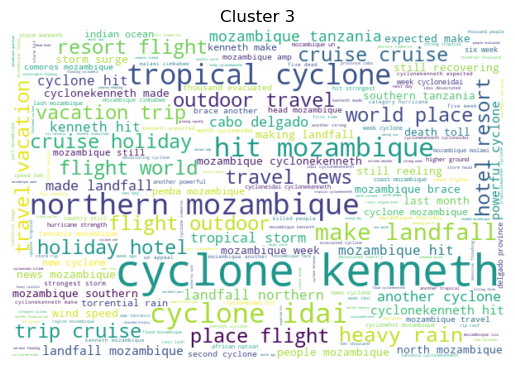

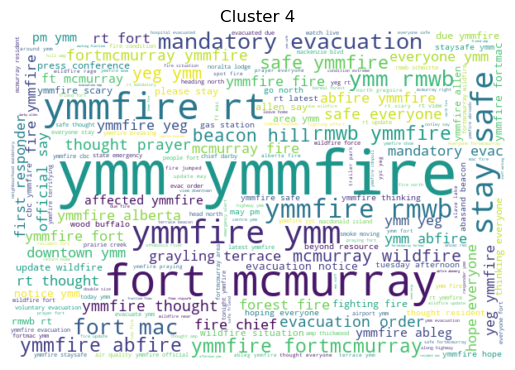

In [51]:
# 7️⃣ Affichage des mots par cluster
for cluster, words in clusters.items():
    print(f"\n🔹 Cluster {cluster} :")
    common_words = Counter(words).most_common(10)
    print([word for word, _ in common_words])

# 8️⃣ Visualisation avec WordCloud
for cluster in range(num_clusters):
    wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(clusters[cluster]))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster}")
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zapat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zapat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



🔹 Traitement des tweets pour l'événement : typhoon 🔹

 Cluster 0 :
['travel', 'cruise', 'flight', 'mozambique', 'news', 'vacation', 'trip', 'holiday', 'hotel', 'resort']

 Cluster 1 :
['mozambique', 'cyclone', 'typhoon', 'cyclonekenneth', 'philippine', 'kenneth', 'hagupit', 'storm', 'rubyph', 'hit']


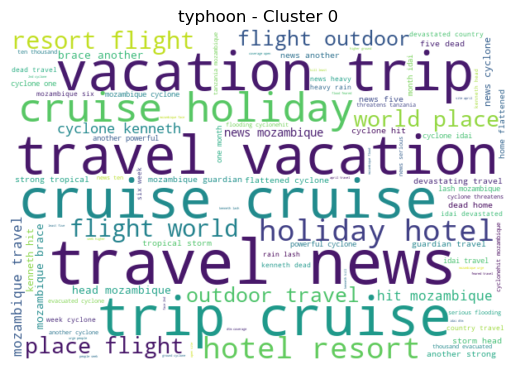

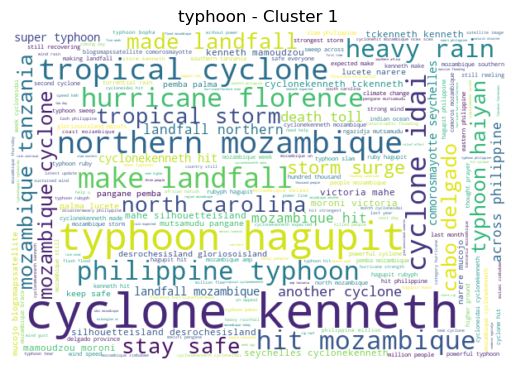


🔹 Traitement des tweets pour l'événement : flood 🔹

 Cluster 0 :
['rt', 'flood', 'bigwet', 'yycflood', 'durban', 'flooding', 'abflood', 'durbanfloods', 'people', 'kzn']

 Cluster 1 :
['south', 'africa', 'flood', 'rain', '51', 'heavy', 'death', 'toll', 'dead', 'rise']


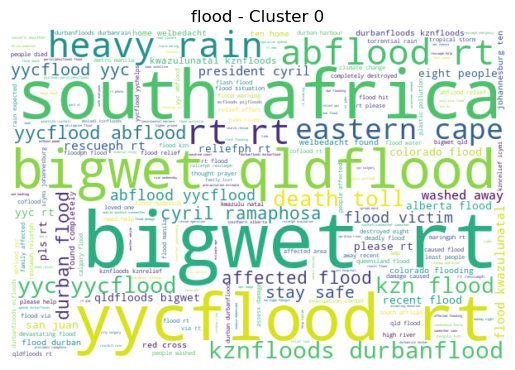

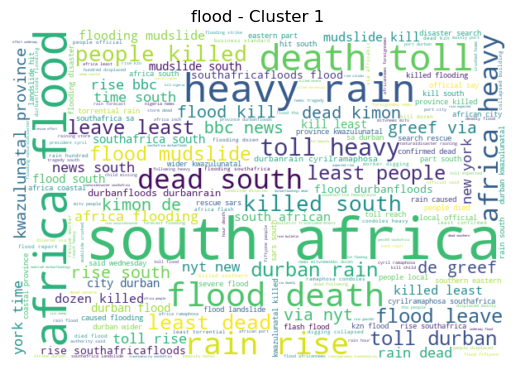


🔹 Traitement des tweets pour l'événement : shooting 🔹

 Cluster 0 :
['shooting', 'school', 'dallas', 'rt', 'police', 'shot', 'protest', 'injured', 'florida', 'officer']

 Cluster 1 :
['synagogue', 'shooting', 'san', 'diego', 'poway', 'injured', 'man', 'california', 'dead', 'people']


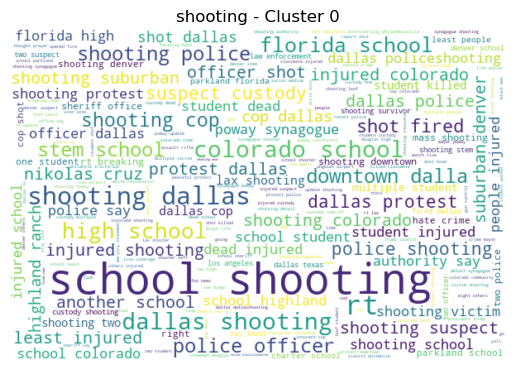

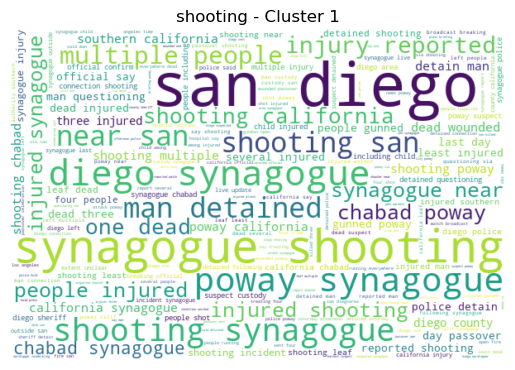


🔹 Traitement des tweets pour l'événement : wildfire 🔹

 Cluster 0 :
['ymmfire', 'ymm', 'rt', 'fort', 'fire', 'mcmurray', 'safe', 'rmwb', 'fortmcmurray', 'evacuation']

 Cluster 1 :
['wildfire', 'fire', 'alberta', 'abfire', 'high', 'level', 'smoke', 'abwildfire', 'highlevel', 'northern']


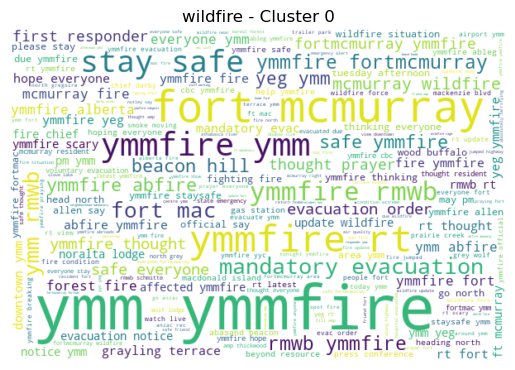

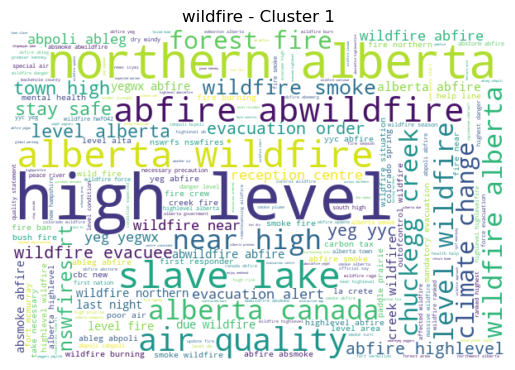


🔹 Traitement des tweets pour l'événement : earthquake 🔹

 Cluster 0 :
['earthquake', 'philippine', 'magnitude', 'hit', 'manila', 'luzon', 'quake', 'safe', 'earthquakeph', 'people']

 Cluster 1 :
['nepal', 'nepalearthquake', 'earthquake', 'help', 'nepalquake', 'prayer', 'amp', 'people', 'u', 'god']


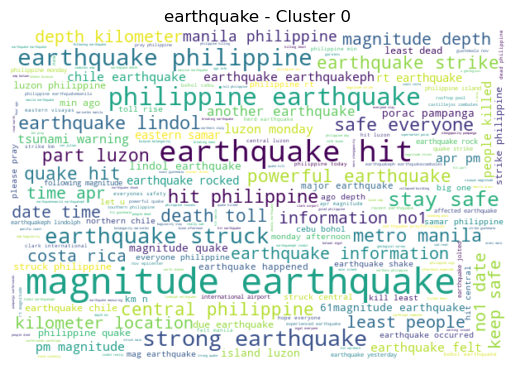

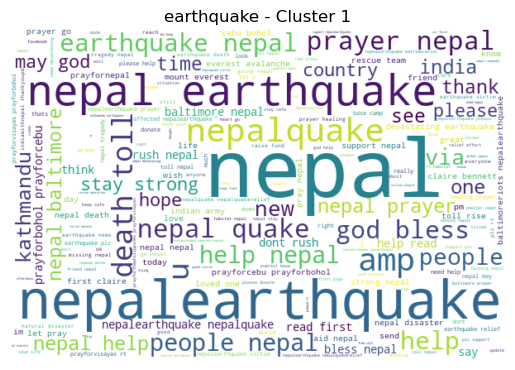


🔹 Traitement des tweets pour l'événement : bombing 🔹

 Cluster 0 :
['paris', 'attack', 'dead', 'hostage', 'explosion', 'least', 'police', 'rt', 'shooting', 'bataclan']

 Cluster 1 :
['paris', 'rt', 'attack', 'prayforparis', 'boston', 'explosion', 'marathon', 'people', 'texas', 'bombing']


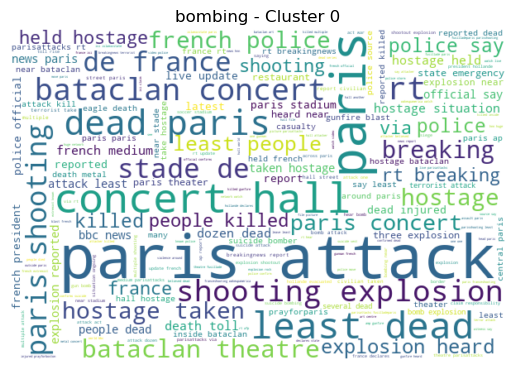

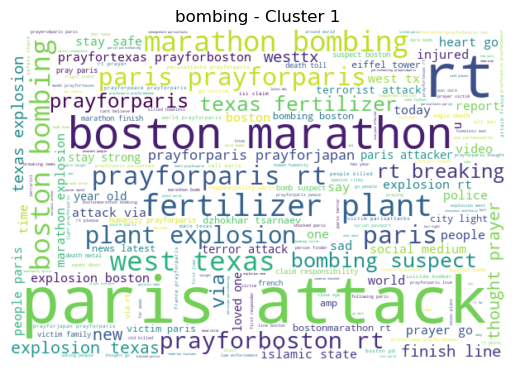

In [52]:
# Téléchargement des ressources NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# 1️⃣ Charger les tweets (exemple avec un fichier CSV)
tweets = bd_clean["text_tweet"].astype(str).tolist()  # Supposons que la colonne s'appelle "tweet_text"
event_types = bd_clean["eventType_event"].tolist()  # Colonne contenant le type d'événement

# 2️⃣ Prétraitement des tweets
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Minuscule
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Supprimer URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Supprimer mentions et hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Supprimer ponctuation
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Stopwords + lemmatisation
    return " ".join(words)

# 3️⃣ Diviser les tweets par type d'événement
event_clusters = {}
for event_type in set(event_types):  # On parcourt tous les types d'événements
    # Filtrer les tweets pour l'événement courant
    event_tweets = [tweets[i] for i in range(len(tweets)) if event_types[i] == event_type]
    event_tweets_clean = [preprocess_text(tweet) for tweet in event_tweets]
    event_clusters[event_type] = event_tweets_clean

# 4️⃣ Appliquer TF-IDF, réduction de dimension, et clustering pour chaque événement
for event_type, event_tweets_clean in event_clusters.items():
    print(f"\n🔹 Traitement des tweets pour l'événement : {event_type} 🔹")
    
    # Vectorisation TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000)
    X_tfidf = vectorizer.fit_transform(event_tweets_clean)

    # Réduction de dimension (facultatif mais utile)
    svd = TruncatedSVD(n_components=100)  # Réduit à 100 dimensions
    X_reduced = svd.fit_transform(X_tfidf)

    # Clustering avec K-Means
    num_clusters = 2  # Nombre de clusters à ajuster
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(X_reduced)
    labels = kmeans.labels_

    # Analyse des clusters
    terms = vectorizer.get_feature_names_out()
    clusters = {i: [] for i in range(num_clusters)}

    for i, label in enumerate(labels):
        clusters[label].extend(event_tweets_clean[i].split())

    # Affichage des mots par cluster
    for cluster, words in clusters.items():
        print(f"\n Cluster {cluster} :")
        common_words = Counter(words).most_common(10)
        print([word for word, _ in common_words])

    # Visualisation avec WordCloud pour chaque cluster
    for cluster in range(num_clusters):
        wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(clusters[cluster]))
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{event_type} - Cluster {cluster}")
        plt.show()



In [53]:
for event_type, event_tweets_clean in event_clusters.items():
    print(f"\n🔹 Traitement des tweets pour l'événement : {event_type} 🔹")
    
    # Vectorisation TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000)
    X_tfidf = vectorizer.fit_transform(event_tweets_clean)

    # Réduction de dimension (facultatif mais utile)
    svd = TruncatedSVD(n_components=100)  # Réduit à 100 dimensions
    X_reduced = svd.fit_transform(X_tfidf)

    # Clustering avec K-Means
    num_clusters = 5  # Nombre de clusters à ajuster
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    kmeans.fit(X_reduced)
    labels = kmeans.labels_

    # 5️⃣ Extraire le top 5 des mots les plus fréquents avec leur score TF-IDF
    terms = vectorizer.get_feature_names_out()
    feature_array = X_tfidf.toarray()

    # Afficher le top 5 des mots avec leur score TF-IDF pour chaque événement
    print(f"\n🔸 Top 5 des mots les plus fréquents pour l'événement '{event_type}' avec leur score TF-IDF :")
    tfidf_scores = {}
    for i, term in enumerate(terms):
        # Moyenne des scores TF-IDF de chaque mot dans tous les tweets
        avg_tfidf_score = feature_array[:, i].mean()
        tfidf_scores[term] = avg_tfidf_score

    # Trier par score et afficher les 5 premiers mots
    sorted_tfidf = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, score in sorted_tfidf:
        print(f"{word}: {score:.4f}")


🔹 Traitement des tweets pour l'événement : typhoon 🔹

🔸 Top 5 des mots les plus fréquents pour l'événement 'typhoon' avec leur score TF-IDF :
typhoon: 0.0345
mozambique: 0.0341
philippine: 0.0323
cyclone: 0.0299
hagupit: 0.0274

🔹 Traitement des tweets pour l'événement : flood 🔹

🔸 Top 5 des mots les plus fréquents pour l'événement 'flood' avec leur score TF-IDF :
flood: 0.0453
rt: 0.0391
south: 0.0307
africa: 0.0301
rain: 0.0230

🔹 Traitement des tweets pour l'événement : shooting 🔹

🔸 Top 5 des mots les plus fréquents pour l'événement 'shooting' avec leur score TF-IDF :
shooting: 0.0723
school: 0.0528
synagogue: 0.0484
dallas: 0.0429
injured: 0.0405

🔹 Traitement des tweets pour l'événement : wildfire 🔹

🔸 Top 5 des mots les plus fréquents pour l'événement 'wildfire' avec leur score TF-IDF :
ymmfire: 0.0480
ymm: 0.0378
wildfire: 0.0357
fire: 0.0348
alberta: 0.0295

🔹 Traitement des tweets pour l'événement : earthquake 🔹

🔸 Top 5 des mots les plus fréquents pour l'événement 'earthqua

C:\Users\zapat\AppData\Local\Temp\ipykernel_22664\2047860786.py:8: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  bd_clean = pd.read_csv("bd_clean.csv")  # Remplace par ton fichier
c:\Users\zapat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\zapat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
c:\Users\zapat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. Yo

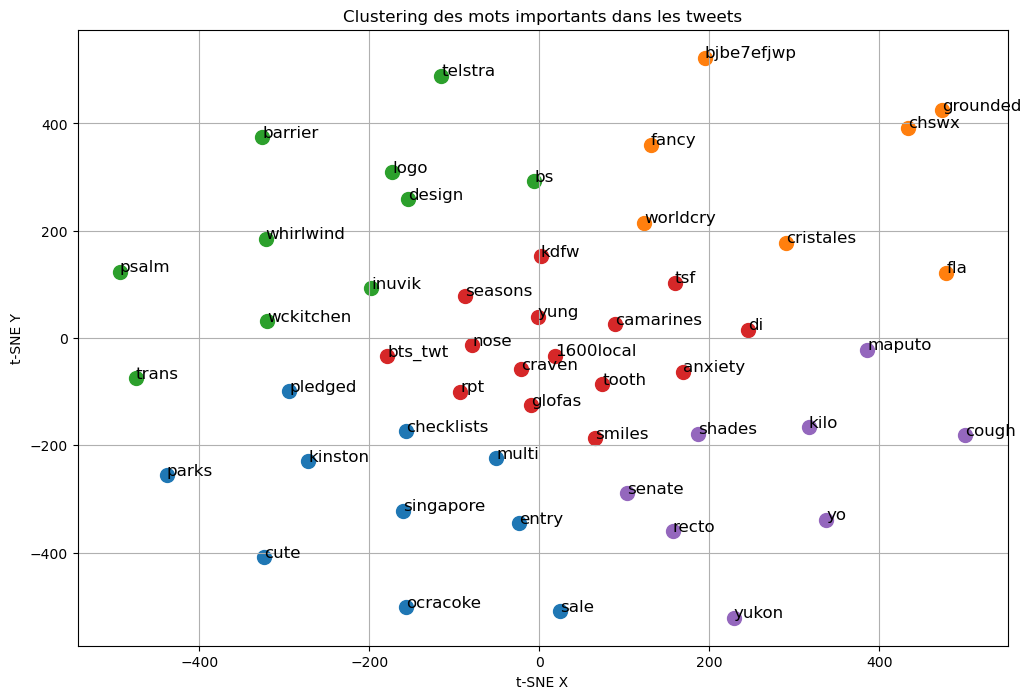

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Charger les tweets
bd_clean = pd.read_csv("bd_clean.csv")  # Remplace par ton fichier
tweets = bd_clean["text_tweet"].astype(str).tolist()

# Étape 1 : Calculer le TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)  # Ajuste max_features si nécessaire
tfidf_matrix = vectorizer.fit_transform(tweets)
vocab = vectorizer.get_feature_names_out()

# Étape 2 : Trouver les k mots avec le plus haut IDF
idf_scores = vectorizer.idf_
top_k = 50  # Nombre de mots importants à extraire
top_k_indices = idf_scores.argsort()[-top_k:]  # Indices des k plus grands IDF
top_k_words = [vocab[i] for i in top_k_indices]

# Étape 3 : Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, init="random", learning_rate=200)
tfidf_2d = tsne.fit_transform(tfidf_matrix.T[top_k_indices].toarray())  # Transposer pour obtenir les vecteurs de mots

# Étape 4 : Clustering avec K-Means
num_clusters = 5  # Ajuste selon tes besoins
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tfidf_2d)

# Étape 5 : Visualisation
plt.figure(figsize=(12, 8))
for i, word in enumerate(top_k_words):
    x, y = tfidf_2d[i, 0], tfidf_2d[i, 1]
    plt.scatter(x, y, c=f"C{clusters[i]}", s=100)  # Couleur selon le cluster
    plt.text(x + 0.1, y + 0.1, word, fontsize=12)

plt.title("Clustering des mots importants dans les tweets")
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.grid(True)
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zapat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zapat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\zapat\AppData\Local\Temp\ipykernel_7568\2532087318.py:18: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  bd_clean = pd.read_csv("bd_clean.csv")  # Remplace par ton fichier
c:\Users\zapat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\zapat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\cont

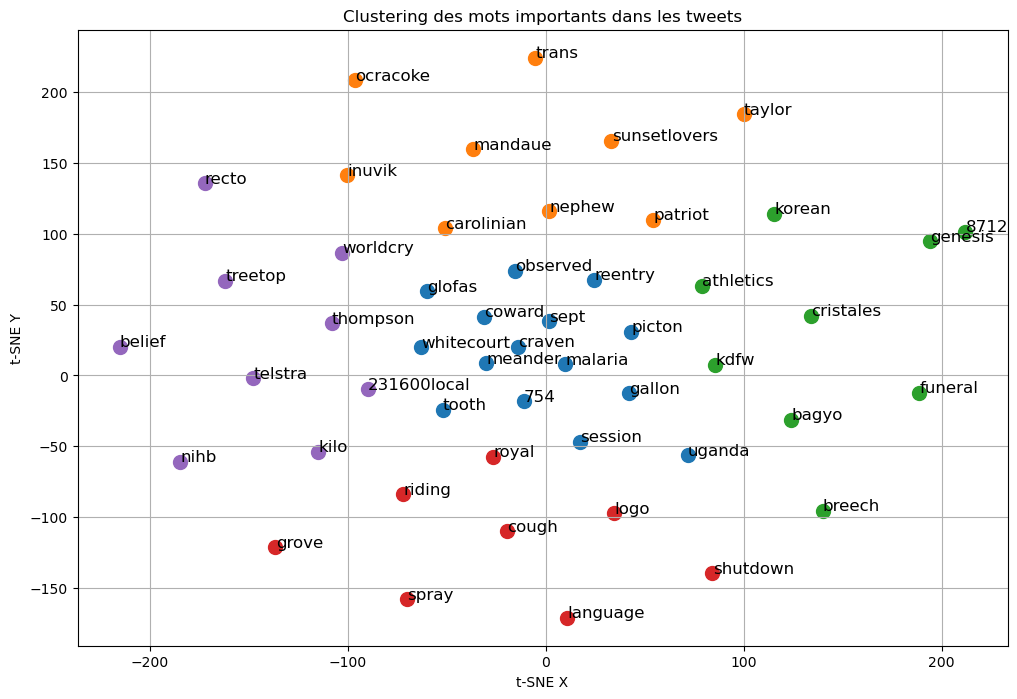

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Charger les tweets
bd_clean = pd.read_csv("bd_clean.csv")  # Remplace par ton fichier
tweets = bd_clean["text_tweet"].astype(str).tolist()

# 2️⃣ Prétraitement des tweets
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Minuscule
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Supprimer URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Supprimer mentions et hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Supprimer ponctuation
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Stopwords + lemmatisation
    return " ".join(words)

# Appliquer le prétraitement
tweets_cleaned = [preprocess_text(tweet) for tweet in tweets]

# Étape 1 : Calculer le TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)  # Ajuste max_features si nécessaire
tfidf_matrix = vectorizer.fit_transform(tweets_cleaned)
vocab = vectorizer.get_feature_names_out()

# Étape 2 : Trouver les k mots avec le plus haut IDF
idf_scores = vectorizer.idf_
top_k = 50  # Nombre de mots importants à extraire
top_k_indices = idf_scores.argsort()[-top_k:]  # Indices des k plus grands IDF
top_k_words = [vocab[i] for i in top_k_indices]

# Étape 3 : Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5, init="random", learning_rate=200)
tfidf_2d = tsne.fit_transform(tfidf_matrix.T[top_k_indices].toarray())  # Transposer pour obtenir les vecteurs de mots

# Étape 4 : Clustering avec K-Means
num_clusters = 5  # Ajuste selon tes besoins
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tfidf_2d)

# Étape 5 : Visualisation
plt.figure(figsize=(12, 8))
for i, word in enumerate(top_k_words):
    x, y = tfidf_2d[i, 0], tfidf_2d[i, 1]
    plt.scatter(x, y, c=f"C{clusters[i]}", s=100)  # Couleur selon le cluster
    plt.text(x + 0.1, y + 0.1, word, fontsize=12)

plt.title("Clustering des mots importants dans les tweets")
plt.xlabel("t-SNE X")
plt.ylabel("t-SNE Y")
plt.grid(True)
plt.show()


# B. Topics addressed in the tweets in the form of word embeddings (ii)

Dans le notebook

# B. Topics addressed in the tweets in the form of tweet embeddings (iii)

In [3]:
bd_clean = pd.read_csv('bd_clean.csv')

C:\Users\zapat\AppData\Local\Temp\ipykernel_22664\2560660895.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  bd_clean = pd.read_csv('bd_clean.csv')


# [Open question] Suggest mining any other information that would be useful in the dashboard.

In [104]:
bd_clean.columns

Index(['node_id_tweet', 'possibly_sensitive_tweet', 'created_at_tweet',
       'retweet_count_tweet', 'is_quote_status_tweet',
       'annotation_postPriority_tweet', 'favorite_count_tweet', 'text_tweet',
       'node_id_user', 'friends_count_user', 'isVerified_user',
       'screen_name_user', 'statuses_count_user', 'favourites_count_user',
       'followers_count_user', 'name_user', 'node_id_event', 'id_event_y',
       'eventType_event', 'node_id_hashtag', 'occurences_hashtag',
       'id_hashtag_y', 'node_id_category', 'id_category', 'date', 'year',
       'month', 'word_counts', 'lang'],
      dtype='object')

In [103]:
bd_clean.head(3)

node_id_tweet  possibly_sensitive_tweet   created_at_tweet  \
0            582                     False  2012-06-09T00:00Z   
1            582                     False  2012-06-09T00:00Z   
2            583                     False  2012-06-09T00:00Z   

   retweet_count_tweet  is_quote_status_tweet annotation_postPriority_tweet  \
0                    0                  False                           Low   
1                    0                  False                           Low   
2                    3                  False                        Medium   

   favorite_count_tweet                                         text_tweet  \
0                     1  #colorado. Told you its #amazing http://t.co/6...   
1                     1  #colorado. Told you its #amazing http://t.co/6...   
2                     0  RT @northfortynews: Tanker helicopter heads up...   

   node_id_user  friends_count_user  ...  node_id_hashtag occurences_hashtag  \
0         56568                 400  ...         100609.0                3.0   
1         56568                 400  ...          99813.0                8.0   
2         56569                4930  ...             89.0              149.0   

   id_hashtag_y  node_id_category            id_category        date  year  \
0       amazing             562.0             Irrelevant  2012-06-09  2012   
1      colorado             562.0             Irrelevant  2012-06-09  2012   
2  HighParkFire             573.0  FirstPartyObservation  2012-06-09  2012   

     month word_counts  lang  
0  2012-06           6    en  
1  2012-06           6    en  
2  2012-06          15    en  

[3 rows x 29 columns]

In [4]:
# Nombre d'utilisateurs uniques
nb_users_uniques = bd_clean['node_id_user'].nunique()

# Nombre de tweets uniques
nb_tweets_uniques = bd_clean['node_id_tweet'].nunique()

# Nombre de types d'événements et liste des types uniques
nb_event_types = bd_clean['eventType_event'].nunique()
types_event = bd_clean['eventType_event'].unique()

# Nombre d'ID d'événements uniques et leur liste
nb_events = bd_clean['id_event_y'].nunique()
events_uniques = bd_clean['id_event_y'].unique()

# Nombre moyen de followers par utilisateur unique
avg_followers = bd_clean.groupby('node_id_user')['followers_count_user'].mean().mean()

# Affichage des résultats
print(f"\n Nombre d'utilisateurs uniques: {nb_users_uniques}")
print(f"\n Nombre de tweets uniques: {nb_tweets_uniques}")
print(f"\n Nombre de types d'événements: {nb_event_types}")
print(f"\n Types d'événements uniques: {types_event}")
print(f"\n Nombre d'ID d'événements uniques: {nb_events}")
print(f"\n ID d'événements uniques: {events_uniques}")
print(f"\n Nombre moyen de followers (par utilisateur unique): {avg_followers:.2f}")



 Nombre d'utilisateurs uniques: 41145

 Nombre de tweets uniques: 53253

 Nombre de types d'événements: 6

 Types d'événements uniques: ['wildfire' 'earthquake' 'flood' 'typhoon' 'shooting' 'bombing']

 Nombre d'ID d'événements uniques: 34

 ID d'événements uniques: ['fireColorado2012' 'costaRicaEarthquake2012' 'floodColorado2013'
 'typhoonPablo2012' 'laAirportShooting2013' 'westTexasExplosion2013'
 'guatemalaEarthquake2012' 'italyEarthquakes2012' 'philipinnesFloods2012'
 'albertaFloods2013' 'australiaBushfire2013' 'bostonBombings2013'
 'manilaFloods2013' 'queenslandFloods2013' 'typhoonYolanda2013'
 'joplinTornado2011' 'chileEarthquake2014' 'typhoonHagupit2014'
 'nepalEarthquake2015' 'flSchoolShooting2018' 'parisAttacks2015'
 'floodChoco2019' 'fireAndover2019' 'earthquakeCalifornia2014'
 'earthquakeBohol2013' 'hurricaneFlorence2018' 'shootingDallas2017'
 'fireYMM2016' 'albertaWildfires2019' 'cycloneKenneth2019'
 'philippinesEarthquake2019' 'coloradoStemShooting2019'
 'southAfricaFlood

In [5]:
# Filtrer les tweets avec eventType_event == 'flood'
flood_tweets = bd_clean[bd_clean['eventType_event'] == 'flood']

# 1. Nombre d'utilisateurs uniques ayant publié des tweets
nb_users_flood = flood_tweets['node_id_user'].nunique()

# 2. Nombre de tweets uniques
nb_tweets_flood = flood_tweets['node_id_tweet'].nunique()

# 3. Pourcentage de tweets retweetés au moins une fois
tweets_retweeted = flood_tweets[flood_tweets['retweet_count_tweet'] > 0]['node_id_tweet'].nunique()
pourcentage_retweet = (tweets_retweeted / nb_tweets_flood) * 100

# 4. Nombre total de retweets
total_retweets = flood_tweets['retweet_count_tweet'].sum()

# 5. Le tweet le plus retweeté
tweet_max_retweet = flood_tweets.loc[flood_tweets['retweet_count_tweet'].idxmax()]
texte_tweet_max_retweet = tweet_max_retweet['text_tweet']

# 6. Nombre et pourcentage de tweets ayant au moins un like
tweets_liked = flood_tweets[flood_tweets['favorite_count_tweet'] > 0]['node_id_tweet'].nunique()
pourcentage_likes = (tweets_liked / nb_tweets_flood) * 100

# 7. Nombre total de likes
total_likes = flood_tweets['favorite_count_tweet'].sum()

# 8. Moyenne des followers des utilisateurs uniques
avg_followers_flood = flood_tweets.groupby('node_id_user')['followers_count_user'].mean().mean()

# 9. Les 3 utilisateurs ayant publié le plus de tweets uniques
top_3_users = flood_tweets.groupby('name_user')['node_id_tweet'].nunique().nlargest(3)

# 10. Pourcentage de chaque valeur de annotation_postPriority_tweet pour chaque tweet unique
priority_percentages = flood_tweets.groupby('annotation_postPriority_tweet')['node_id_tweet'].nunique() / nb_tweets_flood * 100

# 11. Les 5 hashtags les plus récurrents et leur nom
top_5_hashtags = flood_tweets.groupby('id_hashtag_y')['occurences_hashtag'].sum().nlargest(5)

# Affichage des résultats
print(f"\n 1. Nombre d'utilisateurs uniques ayant publié des tweets: {nb_users_flood}")
print(f"\n 2. Nombre de tweets uniques: {nb_tweets_flood}")
print(f"\n 3. Nombre de tweets retweetés au moins une fois: {tweets_retweeted} (Pourcentage: {pourcentage_retweet:.2f}%)")
print(f"\n 4. Nombre total de retweets: {total_retweets}")
print(f"\n 5. Le tweet le plus retweeté: {tweet_max_retweet['node_id_tweet']} avec {tweet_max_retweet['retweet_count_tweet']} retweets")
print(f"Tweet le plus retweeté est: {texte_tweet_max_retweet}")
print(f"\n 6. Nombre de tweets avec au moins un like: {tweets_liked} (Pourcentage: {pourcentage_likes:.2f}%)")
print(f"\n 7. Nombre total de likes: {total_likes}")
print(f"\n 8. Nombre moyen de followers pour les utilisateurs uniques: {avg_followers_flood:.2f}")
print(f"\n 9. Les 3 utilisateurs ayant publié le plus de tweets uniques:")
print(top_3_users)
print(f"\n 10. Pourcentage de chaque valeur de 'annotation_postPriority_tweet':")
print(priority_percentages)
print(f"\n 11. Les 5 hashtags les plus récurrents et leur nom:")
print(top_5_hashtags)



 1. Nombre d'utilisateurs uniques ayant publié des tweets: 5951

 2. Nombre de tweets uniques: 7444

 3. Nombre de tweets retweetés au moins une fois: 4433 (Pourcentage: 59.55%)

 4. Nombre total de retweets: 796194

 5. Le tweet le plus retweeté: 26499 avec 14149 retweets
Tweet le plus retweeté est: RT @CuteEmergency: Look how realistic it is! 

?: bby_hari https://t.co/jux74XONpi

 6. Nombre de tweets avec au moins un like: 2179 (Pourcentage: 29.27%)

 7. Nombre total de likes: 334596

 8. Nombre moyen de followers pour les utilisateurs uniques: 120086.29

 9. Les 3 utilisateurs ayant publié le plus de tweets uniques:
name_user
Queensland Police       32
City of Calgary         20
ABS-CBN News Channel    19
Name: node_id_tweet, dtype: int64

 10. Pourcentage de chaque valeur de 'annotation_postPriority_tweet':
annotation_postPriority_tweet
Critical     0.470177
High         7.455669
Low         32.657174
Medium      13.903815
Unknown     45.513165
Name: node_id_tweet, dtype: float64

In [6]:
# On parcourt chaque type d'événement unique
for event_type in bd_clean['eventType_event'].unique():
    # Filtrer les tweets pour l'événement actuel
    event_tweets = bd_clean[bd_clean['eventType_event'] == event_type]

    # 1. Nombre d'utilisateurs uniques ayant publié des tweets
    nb_users_event = event_tweets['node_id_user'].nunique()

    # 2. Nombre de tweets uniques
    nb_tweets_event = event_tweets['node_id_tweet'].nunique()

    # 3. Pourcentage de tweets retweetés au moins une fois
    tweets_retweeted = event_tweets[event_tweets['retweet_count_tweet'] > 0]['node_id_tweet'].nunique()
    pourcentage_retweet = (tweets_retweeted / nb_tweets_event) * 100

    # 4. Nombre total de retweets
    total_retweets = event_tweets['retweet_count_tweet'].sum()

    # 5. Le tweet le plus retweeté et son texte
    tweet_max_retweet = event_tweets.loc[event_tweets['retweet_count_tweet'].idxmax()]
    texte_tweet_max_retweet = tweet_max_retweet['text_tweet']

    # 6. Nombre et pourcentage de tweets ayant au moins un like
    tweets_liked = event_tweets[event_tweets['favorite_count_tweet'] > 0]['node_id_tweet'].nunique()
    pourcentage_likes = (tweets_liked / nb_tweets_event) * 100

    # 7. Nombre total de likes
    total_likes = event_tweets['favorite_count_tweet'].sum()

    # 8. Moyenne des followers des utilisateurs uniques
    avg_followers_event = event_tweets.groupby('node_id_user')['followers_count_user'].mean().mean()

    # 9. Les 3 utilisateurs ayant publié le plus de tweets uniques
    top_3_users = event_tweets.groupby('screen_name_user')['node_id_tweet'].nunique().nlargest(3)

    # 10. Pourcentage de chaque valeur de annotation_postPriority_tweet pour chaque tweet unique
    priority_percentages = event_tweets.groupby('annotation_postPriority_tweet')['node_id_tweet'].nunique() / nb_tweets_event * 100

    # 11. Les 5 hashtags les plus récurrents et leur nom
    top_5_hashtags = event_tweets.groupby('id_hashtag_y')['occurences_hashtag'].sum().nlargest(5)

    # Affichage des résultats pour cet événement
    print(f"\nStatistiques pour l'événement '{event_type}':")
    print(f"1. Nombre d'utilisateurs uniques ayant publié des tweets: {nb_users_event}")
    print(f"2. Nombre de tweets uniques: {nb_tweets_event}")
    print(f"3. Nombre de tweets retweetés au moins une fois: {tweets_retweeted} (Pourcentage: {pourcentage_retweet:.2f}%)")
    print(f"4. Nombre total de retweets: {total_retweets}")
    print(f"5. Le tweet le plus retweeté: {tweet_max_retweet['node_id_tweet']} avec {tweet_max_retweet['retweet_count_tweet']} retweets")
    print(f"   Texte du tweet le plus retweeté: {texte_tweet_max_retweet}")
    print(f"6. Nombre de tweets avec au moins un like: {tweets_liked} (Pourcentage: {pourcentage_likes:.2f}%)")
    print(f"7. Nombre total de likes: {total_likes}")
    print(f"8. Nombre moyen de followers pour les utilisateurs uniques: {avg_followers_event:.2f}")
    print(f"9. Les 3 utilisateurs ayant publié le plus de tweets uniques:")
    print(top_3_users)
    print(f"10. Pourcentage de chaque valeur de 'annotation_postPriority_tweet':")
    print(priority_percentages)
    print(f"11. Les 5 hashtags les plus récurrents et leur nom:")
    print(top_5_hashtags)



Statistiques pour l'événement 'wildfire':
1. Nombre d'utilisateurs uniques ayant publié des tweets: 4854
2. Nombre de tweets uniques: 7641
3. Nombre de tweets retweetés au moins une fois: 4895 (Pourcentage: 64.06%)
4. Nombre total de retweets: 554534
5. Le tweet le plus retweeté: 51312 avec 15915 retweets
   Texte du tweet le plus retweeté: 'We will not let you get away with it', Greta Thunberg slams politicians for ignoring climate crisis https://t.co/CdqwTVvjYJ
6. Nombre de tweets avec au moins un like: 3713 (Pourcentage: 48.59%)
7. Nombre total de likes: 447717
8. Nombre moyen de followers pour les utilisateurs uniques: 96662.77
9. Les 3 utilisateurs ayant publié le plus de tweets uniques:
name_user
Global Edmonton    79
CTV Edmonton       64
91.1 The Bridge    62
Name: node_id_tweet, dtype: int64
10. Pourcentage de chaque valeur de 'annotation_postPriority_tweet':
annotation_postPriority_tweet
Critical     1.740610
High         7.368146
Low         49.260568
Medium      16.136631
